Imports

In [2]:
%matplotlib inline
# Basic
from collections import OrderedDict
from datetime import datetime, timedelta
from pathlib import Path
import re
# Numbers
import pandas as pd
import numpy as np
# Graphic
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib import patheffects as pe
import seaborn as sns
# Models
import pmdarima as pm
from arch.univariate import ZeroMean, GARCH, Normal # 3 components of GARCH model
import tensorflow as tf
from tensorflow import keras
# Statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS, GLS

Data retrival

In [3]:
# LOAD NAMES
dmkt = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/market_names.csv"
mkt_names = pd.read_csv(dmkt).values.tolist()
mkt_names = [item for sublist in mkt_names for item in sublist]

# LOAD DATA
dd = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/"
dirs = []
data = OrderedDict()
for i in range(len(mkt_names)):
    # concat strings to get directories
    nm = mkt_names[i]
    directory = dd+nm+".csv"
    # store
    dirs.append(directory)
    data[nm] = pd.read_csv(directory)
    del directory, nm

Constant specifications

In [108]:
# SCALING FACTOR
SCALE = 100
DESCALE = 1/SCALE

# AE datastructures
LAGS = 64

# Date parameters
E1 = pd.to_datetime("2020-01-13")
E2 = pd.to_datetime("2020-01-24")
E3 = pd.to_datetime("2020-02-24")
E4 = pd.to_datetime("2020-03-09")

CUT1 = pd.to_datetime("2019-04-29")
CUT2 = pd.to_datetime("2020-06-01")

EXCLUSION = pd.to_datetime("2010-01-01")

# Plot parameters
SCATTER = 25
ALPHA = 0.8
LINEWIDTH = 1.5

TITLE_FONT = {
        'family' : 'normal',
        'weight' : 'normal',
        'size'   : 30
        }

AXIS_FONT = {
        'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15
        }

DATE_FORM  = DateFormatter('%Y-%m-%d')

Notebook Settings

In [5]:
# set data splitting parameters
EVENT = E1

# Toggle Settings
store_stats_results = True
save_ae_results = True
show_plots = True
save_figs = True

# Returns
var_mode = 'log_prices' # alternative = 'log_returns'

# Bounded Scaling
rescale = False

# Cutting out of sample
exclude = True

# Plot settings
plt.style.use('seaborn')
plt.rc('font', **AXIS_FONT)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15)

In [6]:
mkt_names

['KOSPI.Index',
 'JCI.Index',
 'SPX.Index',
 'SHSZ300.Index',
 'SPTSX.Index',
 'NKY.Index',
 'SASEIDX.Index',
 'AS51.Index',
 'JALSH.Index',
 'XU100.Index',
 'UKX.Index',
 'N100.Index',
 'HSI.Index',
 'NIFTY.Index',
 'IMOEX.Index',
 'TFTSEMIB.Index',
 'CAC.Index',
 'DAX.Index',
 'MEXBOL.Index',
 'IBEX.Index',
 'INDU.Index',
 'MERVAL.Index']

Initial Data Wrangling

In [7]:
# select data
MKT = 'HSI.Index' #'SHSZ300.Index' #'SPX.Index'
dataset = data[MKT].copy(deep=True)
# format dates
dataset['date'] = pd.to_datetime(dataset['date'].values)
# change colname for ease of use
dataset = dataset.rename(columns={'date':'date', MKT:'val'})
# keep prices for ML
prices = dataset.copy(deep=True)

if var_mode == 'log_returns':
    # extract price level, calc log_returns, store as dataset
    log_returns = np.log(dataset.val.shift(-1) / dataset.val)
    log_returns = log_returns[~np.isnan(log_returns)]

    dataset.val = log_returns
    del log_returns

elif var_mode == 'log_prices':
    # extract price level, calc log_prices, store as dataset
    log_prices = np.log(np.copy(dataset.val.values))
    log_prices = log_prices[~np.isnan(log_prices)]

    dataset.val = log_prices
    del log_prices
else:
    Exception("Variable calculation not specified. Please specify var_mode with one of the following: ['log_returns', 'log_prices']")

# split dataset
Y = dataset.val
X = pd.concat([pd.to_datetime(dataset.date), pd.Series(range(len(Y)))], axis=1).rename({'date':'date',0:'index'},axis=1)
# X_in = X.index[X.date < EVENT]
# X_out = X.index[X.date >= EVENT]
train = dataset[(dataset["date"] < EVENT)] # & (dataset['date'] > pd.to_datetime("2016-01-01")) 
test = dataset[(dataset["date"] >= EVENT)]
# Inspect
print(
    'TABULAR DATA:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

# retain date seqs
dtrain, dtest = pd.to_datetime(train.date), pd.to_datetime(test.date)
# format structures (and dtypes) for arima
Y, train, test = Y.values, train.val.values, test.val.values
# Inspect and compare
print(
    'DATA VECTORS:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

TABULAR DATA: 
 train.shape:  (2962, 2) 
 test.shape:  (522, 2)
DATA VECTORS: 
 train.shape:  (2962,) 
 test.shape:  (522,)


Storage Directories for Results

In [8]:
d_model_results = 'C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/results/fanomal/stats_models/'

d_arima = d_model_results+'arima_results/'+MKT+'/'
d_arima_plots = d_arima+'plots/'

d_garch = d_model_results+'garch_results/'+MKT+'/'
d_garch_plots = d_garch+'plots/'

d_ae = d_model_results+'ae_results/'+MKT+'/'
d_ae_plots = d_ae+'plots/'
d_ae_models = d_ae+'models/'
d_ae_results = d_ae+'results/'

d_ae_predictions = 'predictions/'
d_ae_error = 'error/'

# Ensure appropriate nested directories exit
Path(d_arima).mkdir(parents=True, exist_ok=True)
Path(d_arima_plots).mkdir(parents=True, exist_ok=True)

Path(d_garch).mkdir(parents=True, exist_ok=True)
Path(d_garch_plots).mkdir(parents=True, exist_ok=True)

Path(d_ae).mkdir(parents=True, exist_ok=True)
Path(d_ae_plots).mkdir(parents=True, exist_ok=True)
Path(d_ae_results).mkdir(parents=True, exist_ok=True)

.______________________________.

ARIMA Modelling

In [9]:
ORDER = (1,1,1)
# construct arima model of order ORDER, keeping data out of sample
arima = pm.ARIMA(order=ORDER, out_of_sample_size=int(test.shape[0]))
fit = arima.fit(Y)
# predict in sample
pred_in = fit.predict_in_sample(start=1, end=Y.shape[0], dynamic=False, return_conf_int=True)
# extract upper & lower confidence intervals of predictions
lw = pd.DataFrame({'date':dataset.date.values, 'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])]}).set_index('date')
up = pd.DataFrame({'date':dataset.date.values, 'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]}).set_index('date')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [10]:
# Build pd.DataFrames to make plotting easier
predicted = pd.DataFrame({
    'date':dataset.date.values,
    # 'actual':Y,
    'predicted':pred_in[0],
    'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])],
    'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]
    }).set_index('date')
train_test = {
    'train':pd.DataFrame({'date':dtrain,'train':train}).set_index('date'),
    'test':pd.DataFrame({'date':dtest,'test':test}).set_index('date')
}
actual = dataset.set_index('date')

ARIMA Plots

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


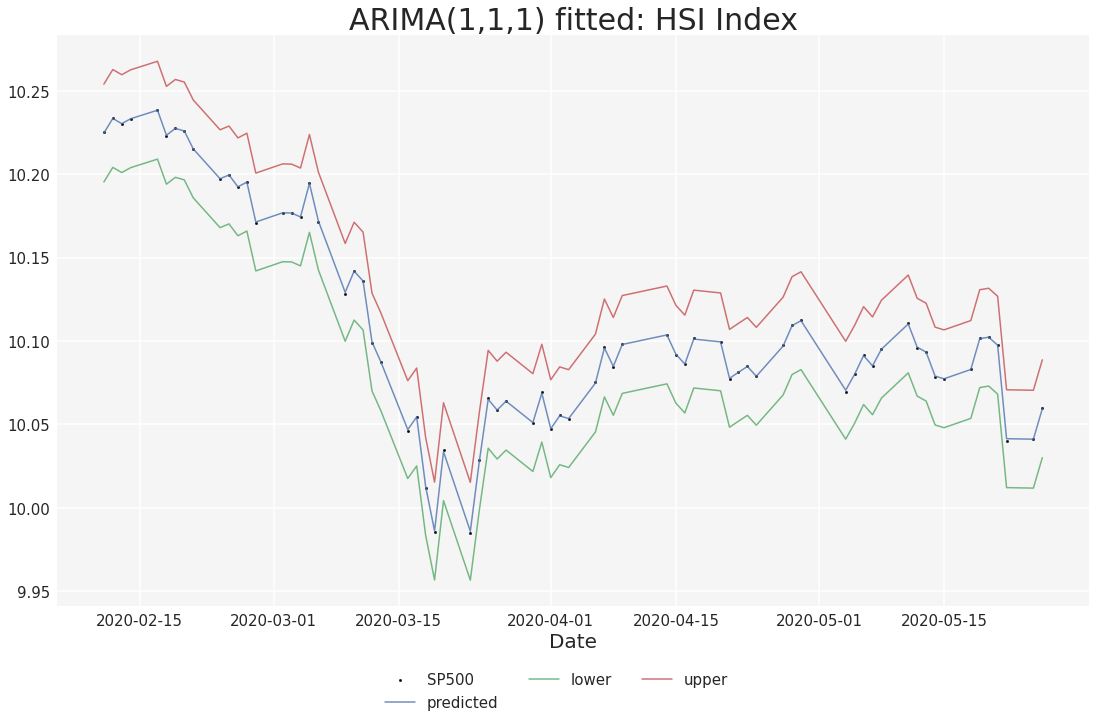

In [11]:
MIN_VAL = 1 + 2980
MAX_VAL = MIN_VAL + test.shape[0] - 450
if show_plots:
    # Plot actual test vs. forecasts:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.fmt_xdata = DATE_FORM
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)
    fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('ARIMA(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)

    plt.show()
else:
    print("Not showing plot.")

if show_plots & save_figs:
    fig.savefig((d_arima_plots+MKT+'_ARIMA'+str(ORDER)+'_full-fit_CLOSE_UP.png'), dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

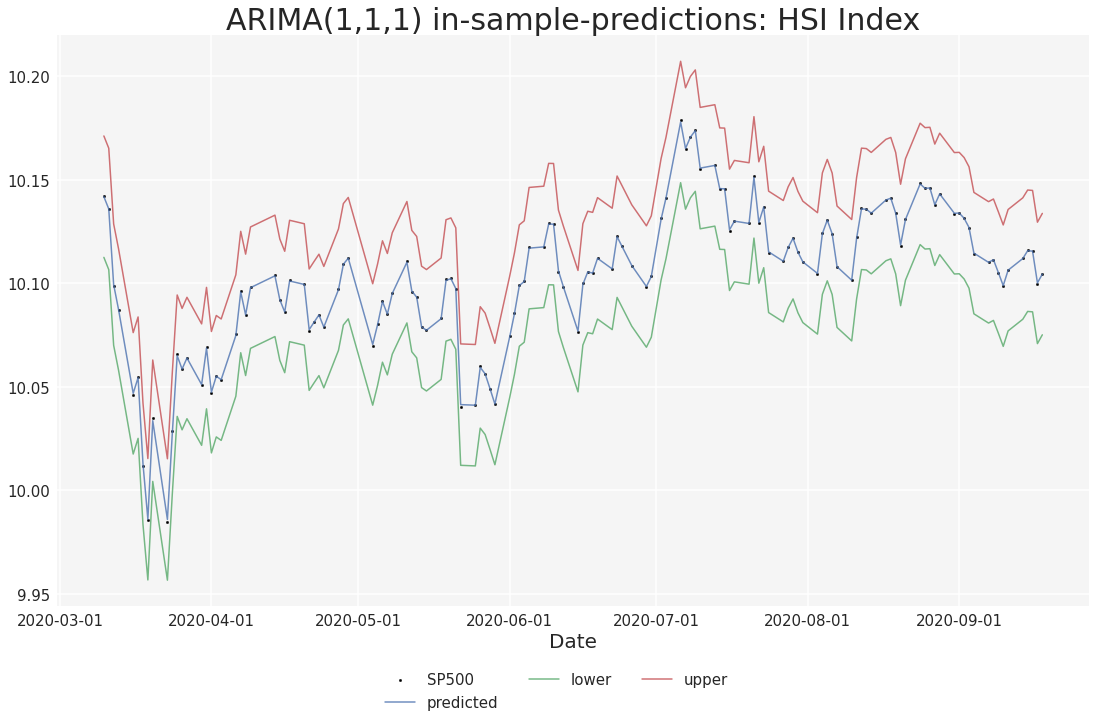

In [12]:
MIN_VAL = 1 + 3000
MAX_VAL = Y.shape[0] - 350
if show_plots:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)
    
    fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('ARIMA(1,1,1) in-sample-predictions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_IN_SAMPLE_PRED_(close_up).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')
# 

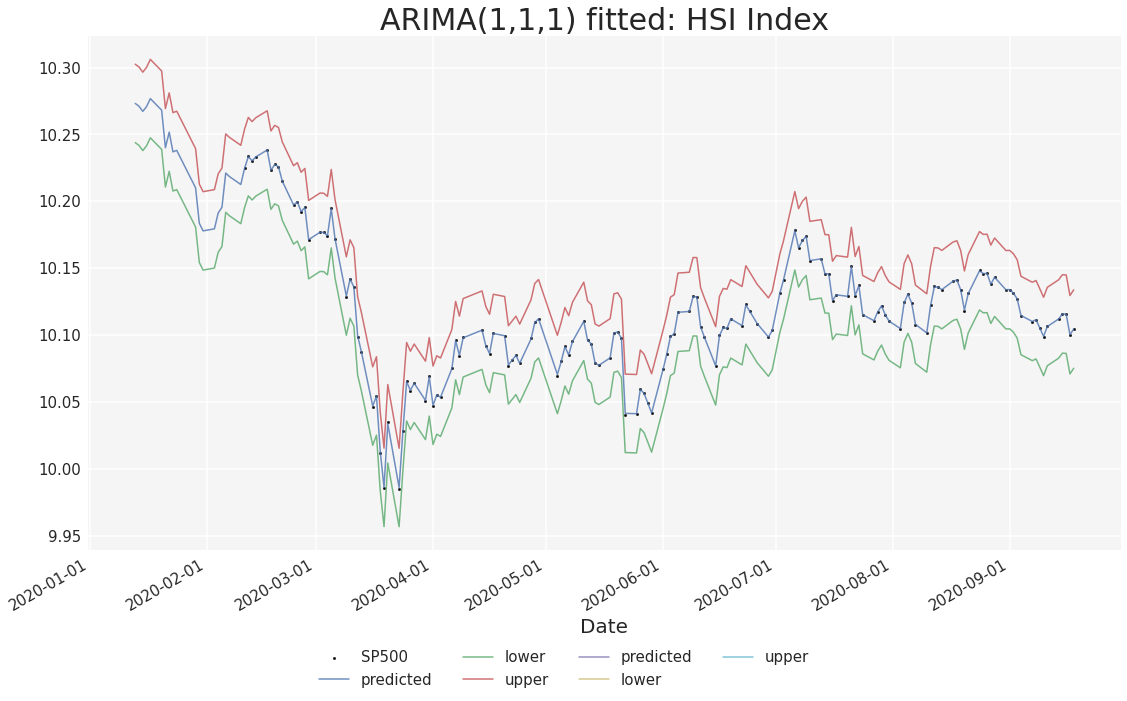

In [13]:
MIN_VAL = 1 + 2980
MAX_VAL = Y.shape[0] - 350
if show_plots:
    # Plot actual test vs. forecasts:
    fig, ax = plt.subplots()
    ax.scatter(
        dataset.date.values[MIN_VAL:MAX_VAL],
        dataset.val.values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[dtrain.shape[0]:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )
    ax.plot(
        predicted.iloc[MIN_VAL:dtrain.shape[0]],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

    ax.set_facecolor('whitesmoke')
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)
    
    fig.legend(loc=8, ncol=4, prop={'size':15})
    fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('ARIMA(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_full-fit_(close_up).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

GARCH Modelling

In [14]:
# Specify forecast horizon
H = 10

# Put ARIMA resids into dataframe to make life easier
arima_resids = pd.DataFrame(
    {'date':dataset.date.values[1:], 'arima_resids':fit.resid()[1:]*SCALE},
    copy=True).set_index('date')
# In-sample Model
garch = ZeroMean(arima_resids)
garch.volatility = GARCH(p=ORDER[0],o=1,q=ORDER[2])
garch.distribution = Normal(seed=1)
garch_fit = garch.fit(last_obs = E1)
# Out-sample Analytic Forecasts
f = garch_fit.forecast(horizon = H, start=E1)

# Conditional Volatilities
# 1-period forward forecast conditional volatility
fvol = pd.DataFrame({'date':f.variance['h.01'].index, 'cond_vol':f.variance['h.01'].pow(0.5)}).set_index('date')
# sample estimated conditional volatility
svol = pd.DataFrame({'date':garch_fit.conditional_volatility.index,'cond_vol':garch_fit.conditional_volatility}).set_index('date')
# All conditional volatility from GARCH model
cvol = pd.concat([svol.dropna(), fvol.dropna()])

# Calculate Y_vol
y_vol = pd.DataFrame(
    {'date':dataset.date.values[1:], 'y_vol':fit.resid()[1:]},
    copy=True).set_index('date').multiply(SCALE).pow(2).pow(0.5) #.multiply(SCALE)

# Calculate GARCH residuals
garch_resids = pd.DataFrame({'date':y_vol.index, 'garch_resids':(y_vol.y_vol.values - cvol.cond_vol.values)}).set_index('date')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1589625728.6983066
Iteration:      2,   Func. Count:     14,   Neg. LLF: 730869473.1426635
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4881.694650366942
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5897.101336629477
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5321.728991428456
Iteration:      6,   Func. Count:     38,   Neg. LLF: 4789.121407829845
Iteration:      7,   Func. Count:     44,   Neg. LLF: 4905.708851489037
Iteration:      8,   Func. Count:     50,   Neg. LLF: 4799.8429296304375
Iteration:      9,   Func. Count:     57,   Neg. LLF: 4798.002781677777
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4783.067082999356
Iteration:     11,   Func. Count:     68,   Neg. LLF: 4783.0641875541405
Iteration:     12,   Func. Count:     73,   Neg. LLF: 4783.064096842821
Iteration:     13,   Func. Count:     78,   Neg. LLF: 4783.06408836486
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4783.064

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


GARCH Plots

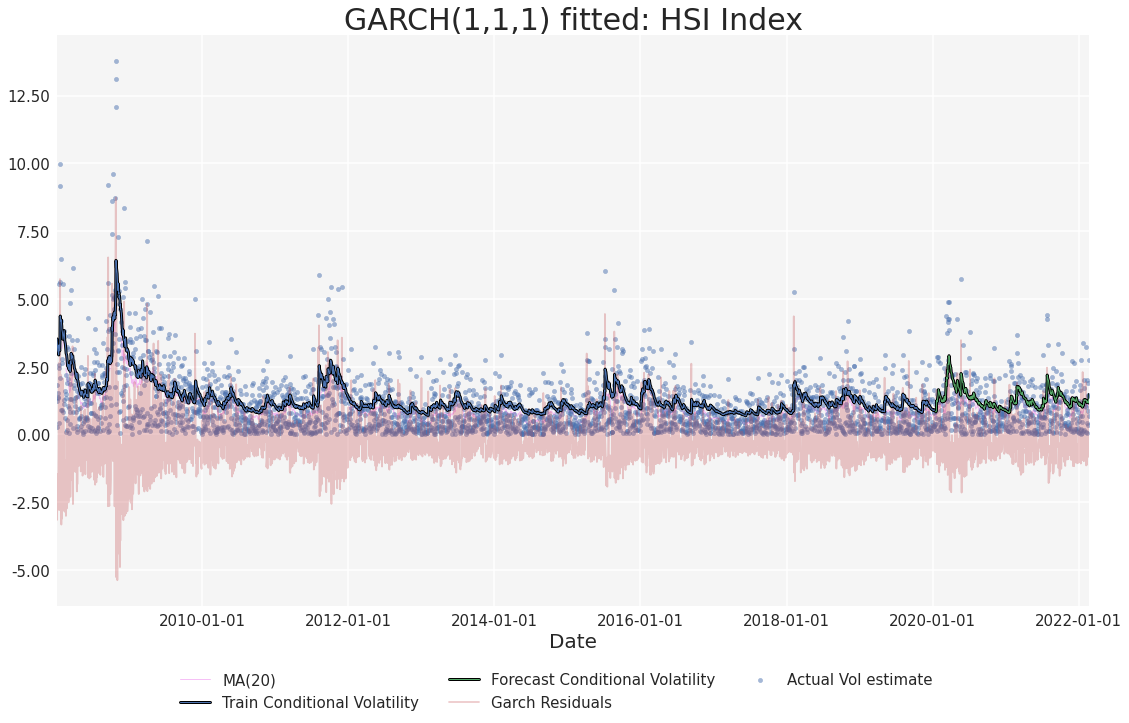

In [15]:
if show_plots:
    # Some formatting
    PE = [pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
    # Plot conditional volatilities
    fig, ax = plt.subplots()
    # ax.plot(garch_fit.conditional_volatility, color='black', label='Full-fit Conditional Volatility')

    ax.plot(y_vol.rolling(window=20).mean(), label='MA(20)', linewidth=1, alpha=0.5, color='violet', zorder=0)

    ax.plot(svol, label='Train Conditional Volatility', linewidth=1, path_effects = PE, zorder=10) #.divide(SCALE).pow(2)
    ax.plot(fvol, label='Forecast Conditional Volatility', linewidth=1, path_effects = PE, zorder=9) #.divide(SCALE).pow(2)
    ax.plot(garch_resids, label='Garch Residuals', alpha=0.3, zorder =2)

    ax.scatter(x=y_vol.index, y=y_vol.values, label='Actual Vol estimate', s=20, alpha=0.5, zorder=1)

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)

    fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
    # fig.autofmt_xdate()
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('GARCH(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_garch_plots+'GRJ-GARCH(1,1,1)_in-sample_vs_out-sample.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [16]:
quiet = svol[svol.index>'2012-01-01']
gfc = svol[svol.index<'2012-01-01']
covid = fvol

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


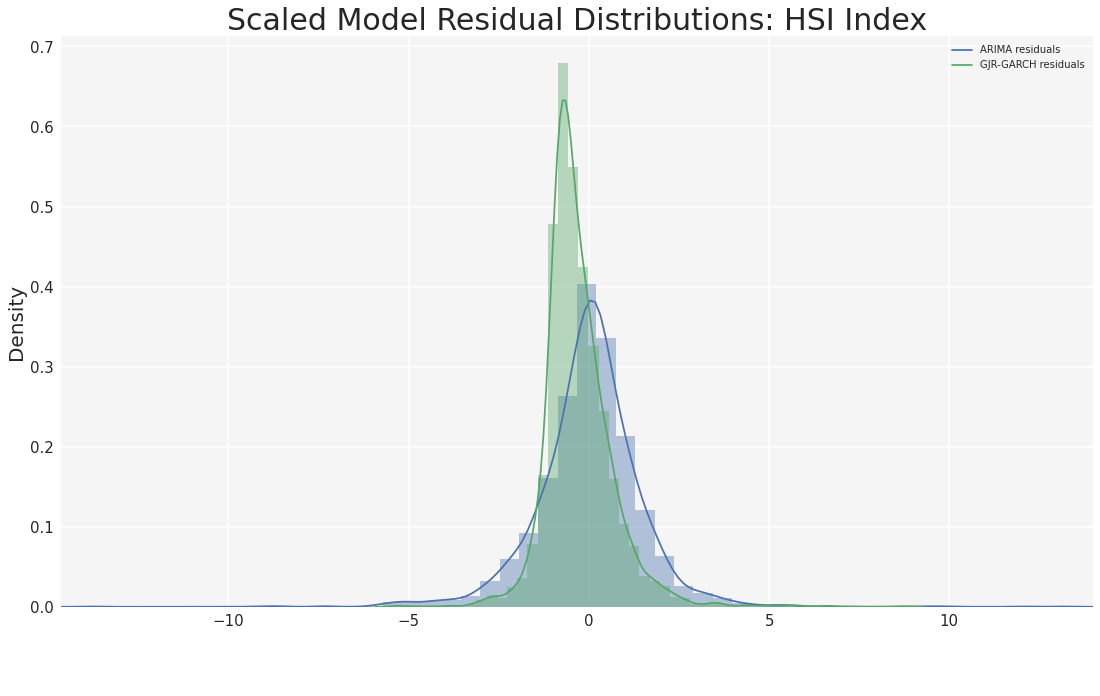

In [17]:
if show_plots:
    fig, ax = plt.subplots()
    
    sns.distplot(arima_resids)
    sns.distplot(garch_resids)

    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)

    fig.legend(loc=8, ncol=1, prop={'size':25})
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('Scaled Model Residual Distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.legend(labels=['ARIMA residuals','GJR-GARCH residuals'])
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_model_results+'ARIMA(1,1,1)_vs_GRJ-GARCH(1,1,1)_residual distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

STORAGE of Results

In [18]:
# RECORD GARCH RESULTS
# Residuals
if store_stats_results:
    garch_resids.to_csv(d_garch+MKT+'_GARCH'+str(ORDER)+'_residuals'+'.csv') 
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(garch_fit.summary().tables[0])
# slice pieces out
tmp1 = df_temp.iloc[0:5,0:2]
tmp2 = df_temp.iloc[0:5,2:4]
tmp3 = df_temp.iloc[6:8,0:2]
tmp4 = df_temp.iloc[5:8,2:4]
# fix colnames
tmp1.columns = ['Item','Value']
tmp2.columns = ['Item','Value']
tmp3.columns = ['Item','Value']
tmp4.columns = ['Item','Value']
# merge and store
if store_stats_results:
    pd.concat([tmp1,tmp2,tmp3,tmp4]).set_index('Item').to_csv(d_garch+MKT+' GJR-GARCH'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4

# Model parameters
df_temp = pd.DataFrame(garch_fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols

if store_stats_results:
    df_temp.drop(0).set_index('name').to_csv(d_garch+MKT+'_GJR-GARCH'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

######################
# RECORD ARIMA RESULTS
# Residuals
if store_stats_results:
    arima_resids.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_residuals'+'.csv')
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(fit.summary().tables[0])
nobs = int(str(df_temp.iloc[5,1]).replace(" ",""))
# slice unruly pieces out
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].drop([5,6],axis=0).rename({2:0,3:1},axis=1)
# wrangle
df_temp = pd.concat([tmp1,tmp2])
df_temp.index = range(len(df_temp))
df_temp = df_temp.drop(5, axis=0)
df_temp.index = range(len(df_temp))
df_temp.iloc[4,1]=tuple([0, nobs])
df_temp.iloc[0:1,1:2] = MKT
df_temp = df_temp.rename({0:'Item',1:'Value'}, axis=1).set_index('Item')

if store_stats_results:
    df_temp.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2

# ARIMA Model coefs & sigs
df_temp = pd.DataFrame(fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols

if store_stats_results:
    df_temp.drop(0).set_index('name').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

# ARIMA statistics
df_temp = pd.DataFrame(fit.summary().tables[2])
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].rename({2:0,3:1},axis=1)

if store_stats_results:
    pd.concat([tmp1,tmp2]).rename({0:'Statistic',1:'Value'}, axis=1).set_index('Statistic').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_statistics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' statistics.')
    # cleanup
    del df_temp, tmp1, tmp2

.______________________________.

AE Prep & Settings

Funcs for data preprocessing

In [19]:
def bounded_scaler(vec, k=[-1,1], scale=True, MIN_MAX = None, SCALE_PARAMS = None):
    MAX = np.max(vec)
    MIN = np.min(vec)
    RANGE = MAX - MIN
    MULT = k[1] - k[0] # mult = b - a

    scale_params = {'min':MIN, 'max':MAX,'range':RANGE, 'b-a':MULT}
    if vec.ndim ==2:
        vec = vec.reshape(vec.shape[0])

    if scale:
        scaled_vec = np.subtract(np.multiply(np.divide(np.subtract(vec,MIN), RANGE), MULT), 1)
        return scaled_vec, scale_params
    elif MIN_MAX:
        if (isinstance(MIN_MAX,dict) == False):
            raise TypeError("MIN_MAX must be an object of dictionary class")
        else:
            RANGE = MIN_MAX['max'] - MIN_MAX['min']
            frac = np.divide(RANGE, MULT)
            unscaled_vec = np.add(np.multiply(np.subtract(vec, k[0]), frac), MIN_MAX['min'])
            del frac
            return unscaled_vec
    elif SCALE_PARAMS:
        if (isinstance(SCALE_PARAMS,dict) == False):
            raise TypeError("SCALE_PARAMS must be an object of dictionary class")
        else:
            frac = np.divide(SCALE_PARAMS['range'], MULT)
            unscaled_vec = np.add(np.multiply(np.subtract(vec, k[0]), frac), SCALE_PARAMS['min'])
            del frac
            return unscaled_vec
    else:
        raise ValueError("I don't know what you want me to do man. Check inputs.")


In [20]:
def lagged_df(vector, lags=LAGS, nans=False, scale=None):
    dct = OrderedDict()
    dct['date'] = vector.index.values #.reshape(len(train.index),1)
    if scale==None:
        for i in range(lags):
            if i ==0:
                dct['l'+str(i)] = vector.values.reshape(len(vector),)
            else:
                dct['l'+str(i)] = vector.shift(i).values.reshape(len(vector),)
    else:
        for i in range(lags):
            if i ==0:
                dct['l'+str(i)] = np.multiply(vector.values.reshape(len(vector),),scale)
            else:
                dct['l'+str(i)] = np.multiply(vector.shift(i).values.reshape(len(vector),),scale)
    if nans:
        df = pd.DataFrame(dct).set_index('date')
    else:
        df = pd.DataFrame(dct).set_index('date').dropna()

    return df

In [21]:
print(
    'testing of results \n',
    all(garch_fit.resid.values == arima_resids.arima_resids.values), '\n',
    all(garch_resids.garch_resids.values == arima_resids.arima_resids.values), '\n',
    all(garch_resids.garch_resids.values == garch_fit.resid.values)
)

testing of results 
 False 
 False 
 False


ARIMA resid features

In [22]:
# specify AE's train and test data
if exclude:
    # Cuts out all data before and incl. the exclusion date
    train, test = arima_resids[(arima_resids.index > EXCLUSION) & (arima_resids.index < EVENT)], arima_resids[(arima_resids.index >= EVENT)]
    train_dates, test_dates, full_dates = train.index, test.index, arima_resids.index
else:
    train, test = arima_resids[(arima_resids.index < EVENT)], arima_resids[(arima_resids.index >= EVENT)]
    train_dates, test_dates, full_dates = train.index, test.index, arima_resids.index

# unscale data
train, test, full = np.multiply(train, DESCALE), np.multiply(test, DESCALE), np.multiply(arima_resids, DESCALE)

if rescale:
    # Rescale to be between [-1,1]
    train, test, full = bounded_scaler(train.values)[0], bounded_scaler(test.values)[0], bounded_scaler(full.values)[0]
    # convert to datetime indexed dataframes
    train, test = pd.DataFrame({'date':train_dates, 'data':train.reshape(len(train))}).set_index('date'), pd.DataFrame({'date':test_dates, 'data':test.reshape(len(test))}).set_index('date')
    full = pd.DataFrame({'date':full_dates, 'data':full.reshape(len(full))}).set_index('date')
else:
    print('Not scaling according to bounds.')
x_train, x_test, x_full = lagged_df(train, lags=LAGS), lagged_df(test, lags=LAGS), lagged_df(full, lags=LAGS)  #  scale=DESCALE 

# Examine dims
print('train shape',train.shape,'\n test shape:',test.shape,'\n long sum:',(train.shape[0]+test.shape[0],test.shape[1]),'\n full shape:',full.shape,'\n')
print('x train shape: ', x_train.shape, '\n x test shape: ', x_test.shape, '\n x full shape: ', x_full.shape)
x_train['l0'].describe()

Not scaling according to bounds.
train shape (2470, 1) 
 test shape: (522, 1) 
 long sum: (2992, 1) 
 full shape: (3483, 1) 

x train shape:  (2407, 64) 
 x test shape:  (459, 64) 
 x full shape:  (3420, 64)


count    2407.000000
mean        0.000164
std         0.011343
min        -0.060366
25%        -0.005756
50%         0.000624
75%         0.006356
max         0.054512
Name: l0, dtype: float64

WandB Tracking & callbacks

In [23]:
# Tracking & callbacks
import wandb
from wandb.keras import WandbCallback

run = wandb.init(
    project='anomal',
    entity='keegangclarke',
    save_code=True,
    reinit=True,
    mode='online', # options are ['online', 'offline', 'disabled']
)
config = run.config

# length of data that will be used to create training dataset
config.train_data = 0.75
config.epochs = 1000
config.validation_split = 1 - config.train_data

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: keegangclarke. Use `wandb login --relogin` to force relogin


AE Specification

In [24]:
# model specification
LAYERS = [64, 46, 28, 10]
config.Lio, config.L2, config.L3, config.Lm  = LAYERS # config.L4, config.L5, config.L6, config.L7, config.L8,
config.act1, config.act2, config.actM, config.actF = ['tanh','tanh','tanh','tanh']
#learning params
config.batch =  256
config.initial = tf.keras.initializers.GlorotNormal()

In [25]:
# Autoencoder
model = keras.Sequential(
    [   
        keras.layers.Flatten(input_shape=(x_train.shape[1],)
        ),
        keras.layers.Dense(
                    config.Lio, activation=config.act1,
        ),
        keras.layers.Dense(
                    config.L2, activation=config.act1,
        ),
        keras.layers.Dense(
                    config.L3, activation=config.act1,
        ),
        keras.layers.Dense(
                    config.Lm, activation=config.actM,
                    kernel_initializer='lecun_normal'
        ),
        keras.layers.Dense(
                    config.L3, activation=config.act2,
        ),
        keras.layers.Dense(
                    config.L2, activation=config.act2,
        ),
        keras.layers.Dense(
                    config.Lio, activation=config.actF,
        ),
        keras.layers.Reshape((x_train.shape[1],)
        ),
    ]
)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 46)                2990      
                                                                 
 dense_2 (Dense)             (None, 28)                1316      
                                                                 
 dense_3 (Dense)             (None, 10)                290       
                                                                 
 dense_4 (Dense)             (None, 28)                308       
                                                                 
 dense_5 (Dense)             (None, 46)                1

Train AE

In [26]:
def round_seconds(obj: datetime) -> datetime:
    if obj.microsecond >= 500_000:
        obj += timedelta(seconds=1)
    return obj.replace(microsecond=0)

In [27]:
# give mode storage name which incl. meta data
MODEL = 'AE'+str(LAYERS)+'__'+str(pd.to_datetime(round_seconds(datetime.now()))).replace(':','_').replace(' ','__T_')
# fit model
history = model.fit(
    x=x_train, 
    y=x_train,
    batch_size=config.batch,
    epochs=config.epochs,
    validation_split=config.validation_split,
    shuffle=False,
    callbacks=[
        WandbCallback(),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
            )
    ]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/1000
1/8 [==>...........................] - ETA: 4s - loss: 1.7908e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 252ms/step - loss: 1.9957e-04 - val_loss: 1.4042e-04
Epoch 2/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.4634e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 252ms/step - loss: 1.5986e-04 - val_loss: 1.2455e-04
Epoch 3/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.3062e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 320ms/step - loss: 1.4303e-04 - val_loss: 1.1663e-04
Epoch 4/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.2215e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 301ms/step - loss: 1.3572e-04 - val_loss: 1.1235e-04
Epoch 5/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.1817e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 275ms/step - loss: 1.3125e-04 - val_loss: 1.0961e-04
Epoch 6/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.1524e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 276ms/step - loss: 1.2850e-04 - val_loss: 1.0763e-04
Epoch 7/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.1332e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 243ms/step - loss: 1.2631e-04 - val_loss: 1.0605e-04
Epoch 8/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.1166e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 308ms/step - loss: 1.2460e-04 - val_loss: 1.0474e-04
Epoch 9/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.1034e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 314ms/step - loss: 1.2311e-04 - val_loss: 1.0361e-04
Epoch 10/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0916e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 233ms/step - loss: 1.2179e-04 - val_loss: 1.0262e-04
Epoch 11/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0814e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 287ms/step - loss: 1.2061e-04 - val_loss: 1.0173e-04
Epoch 12/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0720e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 281ms/step - loss: 1.1954e-04 - val_loss: 1.0095e-04
Epoch 13/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0638e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.1s


8/8 [==============================] - 2s 249ms/step - loss: 1.1856e-04 - val_loss: 1.0024e-04
Epoch 14/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0564e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 216ms/step - loss: 1.1769e-04 - val_loss: 9.9614e-05
Epoch 15/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0498e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 291ms/step - loss: 1.1689e-04 - val_loss: 9.9052e-05
Epoch 16/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0439e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 220ms/step - loss: 1.1617e-04 - val_loss: 9.8552e-05
Epoch 17/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0386e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 269ms/step - loss: 1.1552e-04 - val_loss: 9.8103e-05
Epoch 18/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0338e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 301ms/step - loss: 1.1491e-04 - val_loss: 9.7697e-05
Epoch 19/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0295e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 252ms/step - loss: 1.1436e-04 - val_loss: 9.7328e-05
Epoch 20/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0255e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 1s 209ms/step - loss: 1.1386e-04 - val_loss: 9.6996e-05
Epoch 21/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0219e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 1s 206ms/step - loss: 1.1340e-04 - val_loss: 9.6708e-05
Epoch 22/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0186e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 283ms/step - loss: 1.1299e-04 - val_loss: 9.6469e-05
Epoch 23/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0159e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 237ms/step - loss: 1.1262e-04 - val_loss: 9.6278e-05
Epoch 24/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0136e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 220ms/step - loss: 1.1231e-04 - val_loss: 9.6133e-05
Epoch 25/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0118e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 299ms/step - loss: 1.1204e-04 - val_loss: 9.6027e-05
Epoch 26/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0104e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 275ms/step - loss: 1.1182e-04 - val_loss: 9.5953e-05
Epoch 27/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0093e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 314ms/step - loss: 1.1162e-04 - val_loss: 9.5902e-05
Epoch 28/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0084e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 348ms/step - loss: 1.1145e-04 - val_loss: 9.5867e-05
Epoch 29/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0077e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 213ms/step - loss: 1.1129e-04 - val_loss: 9.5843e-05
Epoch 30/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0072e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 229ms/step - loss: 1.1115e-04 - val_loss: 9.5828e-05
Epoch 31/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0067e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 248ms/step - loss: 1.1102e-04 - val_loss: 9.5820e-05
Epoch 32/1000
1/8 [==>...........................] - ETA: 0s - loss: 1.0064e-04INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221128_140835-2xlqk7fr\files\model-best)... Done. 0.0s


8/8 [==============================] - 2s 348ms/step - loss: 1.1089e-04 - val_loss: 9.5817e-05
Epoch 33/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.1077e-04 - val_loss: 9.5818e-05
Epoch 34/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.1065e-04 - val_loss: 9.5820e-05
Epoch 35/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.1054e-04 - val_loss: 9.5824e-05
Epoch 36/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.1043e-04 - val_loss: 9.5827e-05
Epoch 37/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.1032e-04 - val_loss: 9.5830e-05
Epoch 38/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.1021e-04 - val_loss: 9.5833e-05
Epoch 39/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.1010e-04 - val_loss: 9.5834e-05
Epoch 40/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.0999e-04 - val_loss: 9.5835e-05
Epoch 41/1000
8/8 [==============================

AE Save

In [28]:
d_current_ae = d_ae_models+MODEL+'/'
Path(d_current_ae).mkdir(parents=True, exist_ok=True)

# save model
history.model.save(d_current_ae+MODEL+'.h5',save_format='h5')

# Get Model Summary as pd.DataFrame to store
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
summ_string = "\n".join(stringlist) # entire summary in a variable
table = stringlist[1:-4][1::2] # take every other element and remove appendix
new_table = []
for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)

model_summary = pd.DataFrame(new_table[1:], columns=new_table[0]).to_csv(d_current_ae+MODEL+'_SUMMARY.csv')

# run.finish()

AE Predict

In [29]:
def unlag_df(df, nans=True):
    i = 0
    keys = df.columns
    for key in keys:
        df[key] = df[key].shift(-i)
        i += 1
    return df

In [68]:
# Get predictions
x_train_pred, x_test_pred, x_full_pred = history.model.predict(x_train), history.model.predict(x_test), history.model.predict(x_full)

print('train: ',x_train_pred.shape, '\n test: ', x_test_pred.shape)
lag_keys = ['l'+str(i) for i in range(LAGS)]

# Pandas.DataFrames for ease of use
train_pred = pd.DataFrame(x_train_pred, columns=lag_keys, index=x_train.index)
test_pred = pd.DataFrame(x_test_pred, columns=lag_keys, index=x_test.index)
full_pred = pd.DataFrame(x_full_pred, columns=lag_keys, index=x_full.index)

ewm_full_pred = full_pred.ewm(halflife=1/LAGS,axis=1).mean().sum(axis=1)

# LOSSES
# Absolute errors
train_mae = (train_pred - x_train).abs()#.mean(axis=1)
test_mae = (test_pred - x_test).abs()#.mean(axis=1)
full_mae = (full_pred - x_full).abs()#.mean(axis=1)

# MSE loss
# Crossectional 
train_mse_loss = (train_pred - x_train).pow(2).mean(axis=1)
test_mse_loss = (test_pred - x_test).pow(2).mean(axis=1)
full_mse_loss = (full_pred - x_full).pow(2).mean(axis=1)
# Per Feature
train_mse = (train_pred - x_train).pow(2).mean(axis=0)
test_mse = (test_pred - x_test).pow(2).mean(axis=0)
full_mse = (full_pred - x_full).pow(2).mean(axis=0)
# Unshifted Crossectional
reshifted_rmse_loss = unlag_df(full_pred - x_full).dropna().pow(2).mean(axis=1)
# Unshifted Lags
unshifted_rmse = unlag_df(full_pred - x_full).dropna().pow(2).mean(axis=0)

# RMSE loss
# Crossectional
train_rmse_loss = train_mse_loss.pow(0.5)
test_rmse_loss = test_mse_loss.pow(0.5)
full_rmse_loss = full_mse_loss.pow(0.5)
# Per Feature
train_rmse = train_mse.pow(0.5)
test_rmse = test_mse.pow(0.5)
full_rmse = full_mse.pow(0.5)

# Get MAE loss
train_mae_loss = (train_pred - x_train).abs().mean(axis=1)
test_mae_loss = (test_pred - x_test).abs().mean(axis=1)
full_mae_loss = (full_pred - x_full).abs().mean(axis=1)


prices = prices.set_index('date')

107/107 [==============================] - 0s 658us/step
train:  (2407, 64) 
 test:  (459, 64)


KeyError: "None of ['date'] are in the columns"

AE Save predictions

In [31]:
str(MODEL).replace(', ','-')

'AE[64-46-28-10]__2022-11-28__T_14_08_42'

In [32]:
if save_ae_results:
    # Create directories
    Path(d_current_ae+d_ae_predictions).mkdir(parents=True, exist_ok=True)
    Path(d_current_ae+d_ae_error).mkdir(parents=True, exist_ok=True)

    # Predictions
    train_pred.to_csv(path_or_buf=d_current_ae+d_ae_predictions+'TRAIN_PRED__'+MODEL+'.csv')
    test_pred.to_csv(d_current_ae+d_ae_predictions+'TEST_PRED__'+MODEL+'.csv')
    full_pred.to_csv(d_current_ae+d_ae_predictions+'FULL_PRED__'+MODEL+'.csv')

    # Error
    train_mse_loss.to_csv(d_current_ae+d_ae_error+'TRAIN_PRED_MSE__'+MODEL+'.csv')
    test_mse_loss.to_csv(d_current_ae+d_ae_error+'TEST_PRED_MSE__'+MODEL+'.csv')
    full_mse_loss.to_csv(d_current_ae+d_ae_error+'FULL_PRED_MSE__'+MODEL+'.csv')
    
    train_mae_loss.to_csv(d_current_ae+d_ae_error+'TRAIN_PRED_MAE__'+MODEL+'.csv')
    test_mae_loss.to_csv(d_current_ae+d_ae_error+'TEST_PRED_MAE__'+MODEL+'.csv')
    full_mae_loss.to_csv(d_current_ae+d_ae_error+'FULL_PRED_MAE__'+MODEL+'.csv')
    
else:
    print('Not saving model results')

AE Plots

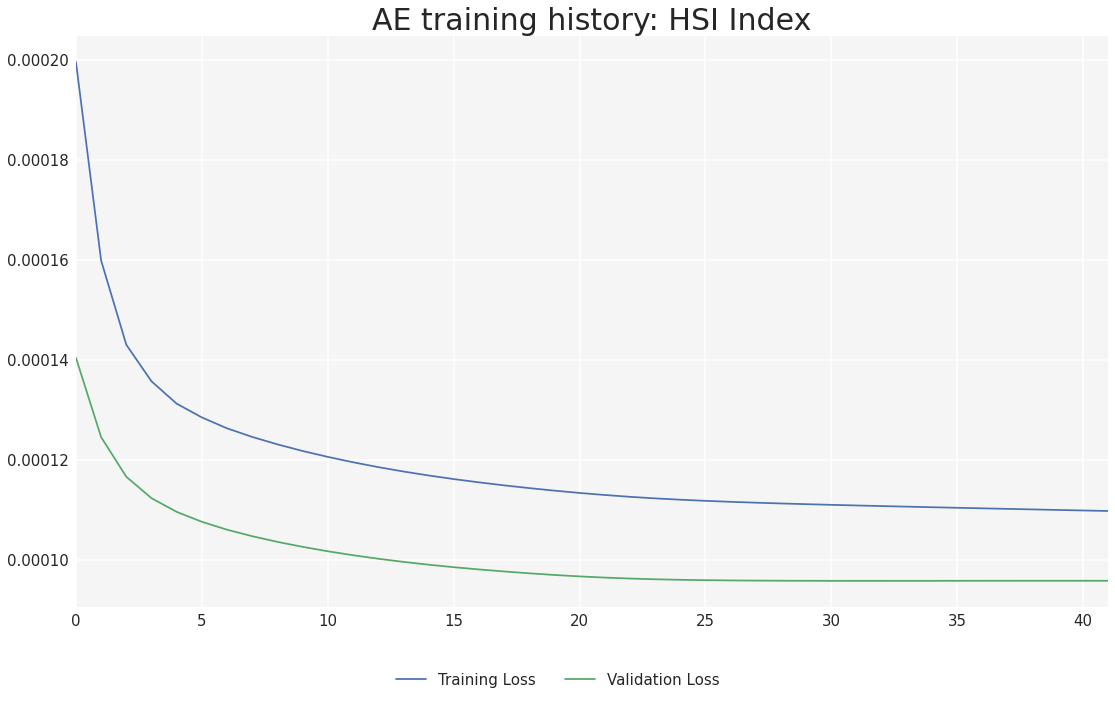

In [33]:
if show_plots:
    fig, ax = plt.subplots()

    ax.plot(history.history["loss"], label="Training Loss")
    ax.plot(history.history["val_loss"], label="Validation Loss")

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    fig.legend(loc=8, ncol=2, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)

    plt.title('AE training history: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_Training_history.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

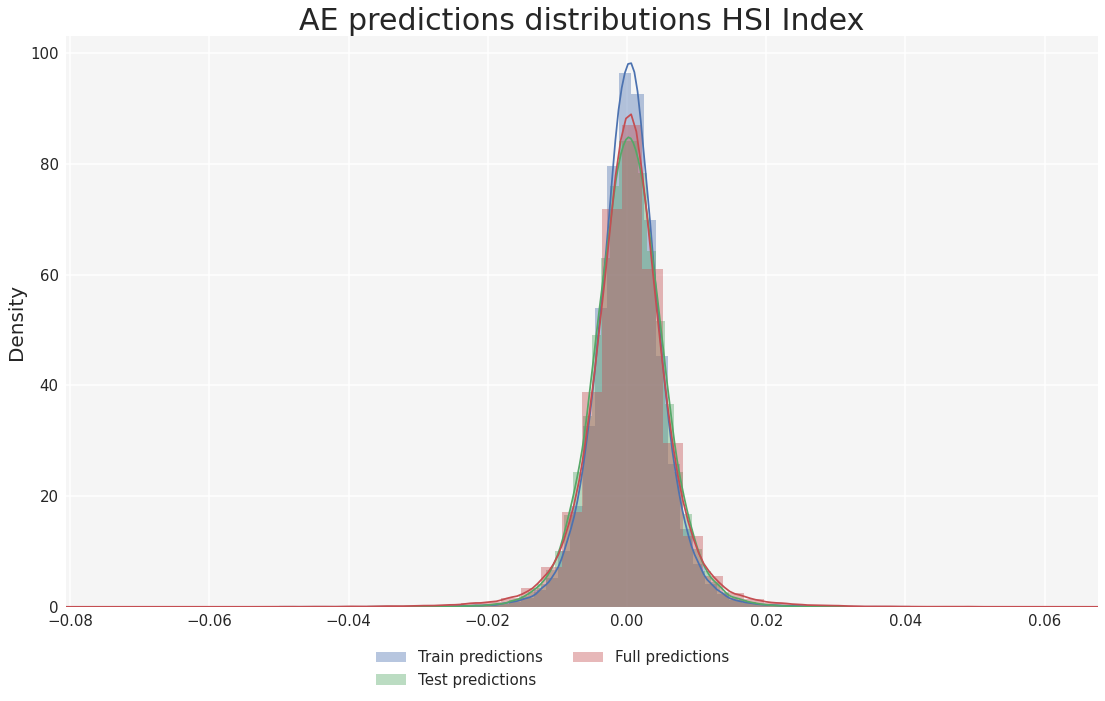

In [34]:
if show_plots:
    fig, ax = plt.subplots()

    sns.distplot(x_train_pred.reshape(x_train_pred.shape[1], x_train_pred.shape[0]), label='Train predictions')
    sns.distplot(x_test_pred.reshape(x_test_pred.shape[1], x_test_pred.shape[0]), label='Test predictions')
    sns.distplot(x_full_pred.reshape(x_full_pred.shape[1], x_full_pred.shape[0]), label='Full predictions')
    # sns.distplot(mean_full_pred, label='Mean predictions')

    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)

    fig.legend(loc=8, ncol=2, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE predictions distributions '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_predictions_distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

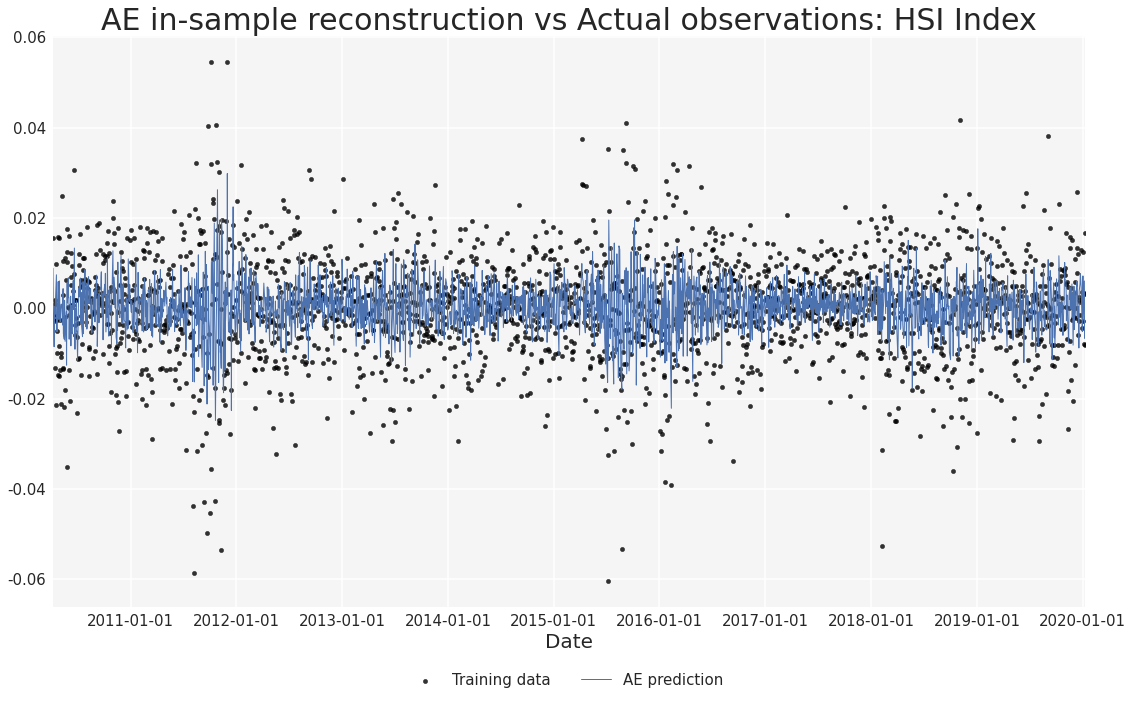

In [35]:
if show_plots:
    fig, ax = plt.subplots()

    ax.scatter(x_train['l0'].index,x_train['l0'], alpha=.8, s=20, color='black', label='Training data')
    ax.plot(train_pred['l0'], linewidth=1, label='AE prediction')
    # for i in range(train_pred.shape[1]):
    #     ax.plot(train_pred['l'+str(i)],linewidth=0.5) #, label = 'l'+str(i)

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)
    
    fig.legend(loc=8, ncol=16, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE in-sample reconstruction vs Actual observations: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_in-sample_reconstruction_vs_actual__lag(0).png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

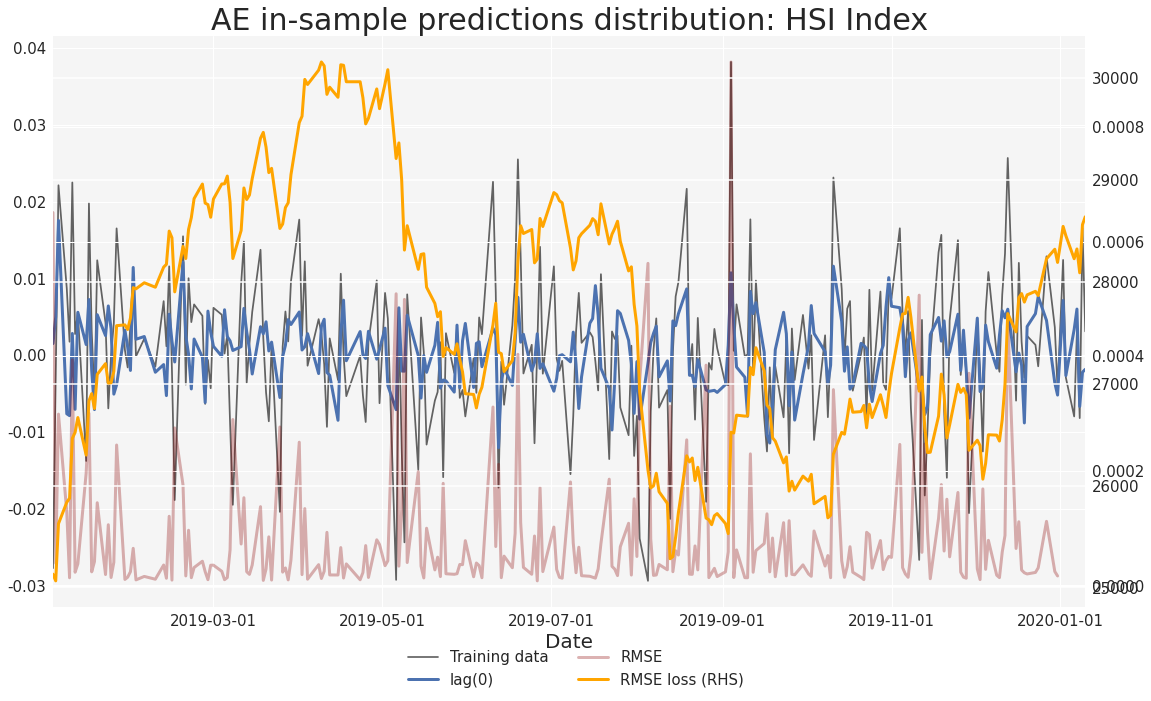

In [65]:
if show_plots:
    fig, ax = plt.subplots()
    
    ax.plot(x_train['l0'][x_train.index>'2019-01-01'], alpha=.6, color='black', label='Training data')
    ax.plot(train_pred['l0'][train_pred.index>'2019-01-01'], label = 'lag(0)', linewidth=3)
    ax2 = ax.twinx()
    ax2.plot(reshifted_rmse_loss[(reshifted_rmse_loss.index>'2019-01-01')&(reshifted_rmse_loss.index<'2020-01-01')],
            label = 'RMSE', linewidth=3, color='darkred', alpha=0.3)
    # ax2.plot(train_rmse_loss[train_pred.index>'2019-01-01'], label = 'RMSE', linewidth=3, color='darkred')
    # ax2.plot(train_mae['l0'][train_pred.index>'2019-01-01'], label = 'RMSE', linewidth=3, color='red')
    ax3 = ax.twinx()
    ax3.plot(prices[(prices.index>'2019-01-01')&(prices.index<='2020-01-10')], color='orange', label=(MKT+'Price Level'), linewidth=3)
    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)
    
    fig.legend(loc=8, ncol=2, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE in-sample predictions distribution: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_in-sample_predictions_vs_actual__close-up.png',
    dpi=400, facecolor='white', edgecolor='white', bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

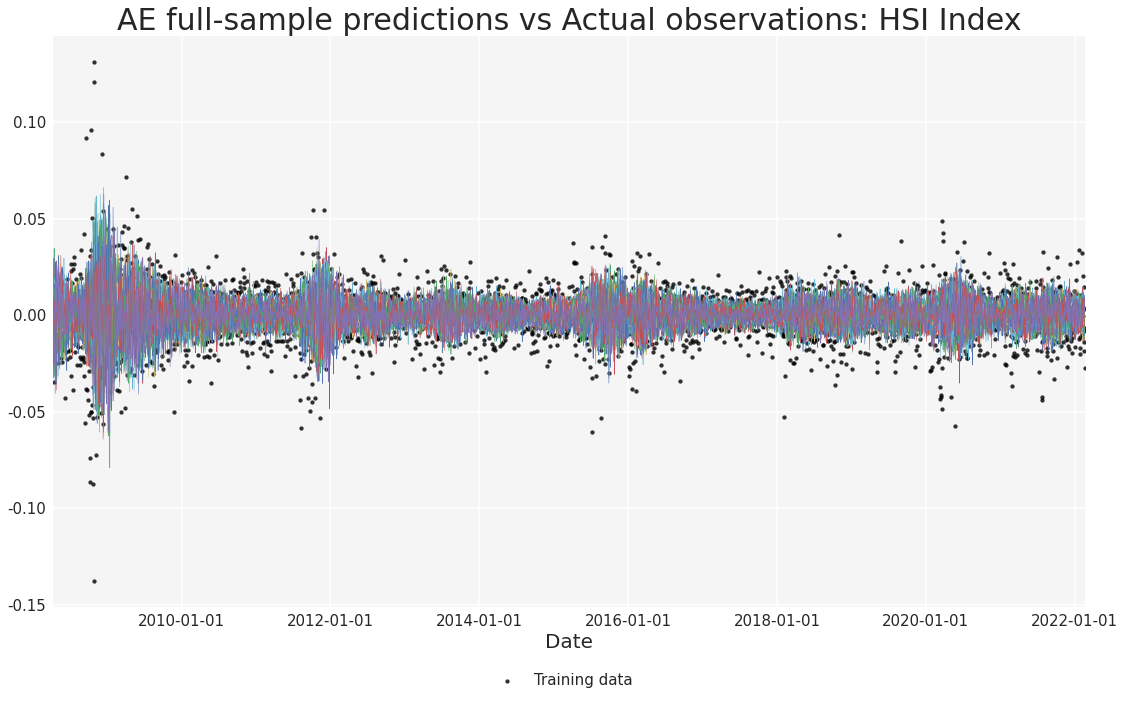

In [37]:
if show_plots:
    fig, ax = plt.subplots()

    ax.scatter(x_full['l0'].index,x_full['l0'], alpha=.8, s=15, color='black', label='Training data')
    for i in range(full_pred.shape[1]):
        ax.plot(full_pred['l'+str(i)], linewidth=0.5) #, label = 'l'+str(i)

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)
    
    fig.legend(loc=8, ncol=16, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE full-sample predictions vs Actual observations: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_full-sample_predictions_vs_actual.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [38]:
print(E1,'\n',E2,'\n',E3,'\n',E4,'\n',)

2020-01-13 00:00:00 
 2020-01-24 00:00:00 
 2020-02-24 00:00:00 
 2020-03-09 00:00:00 



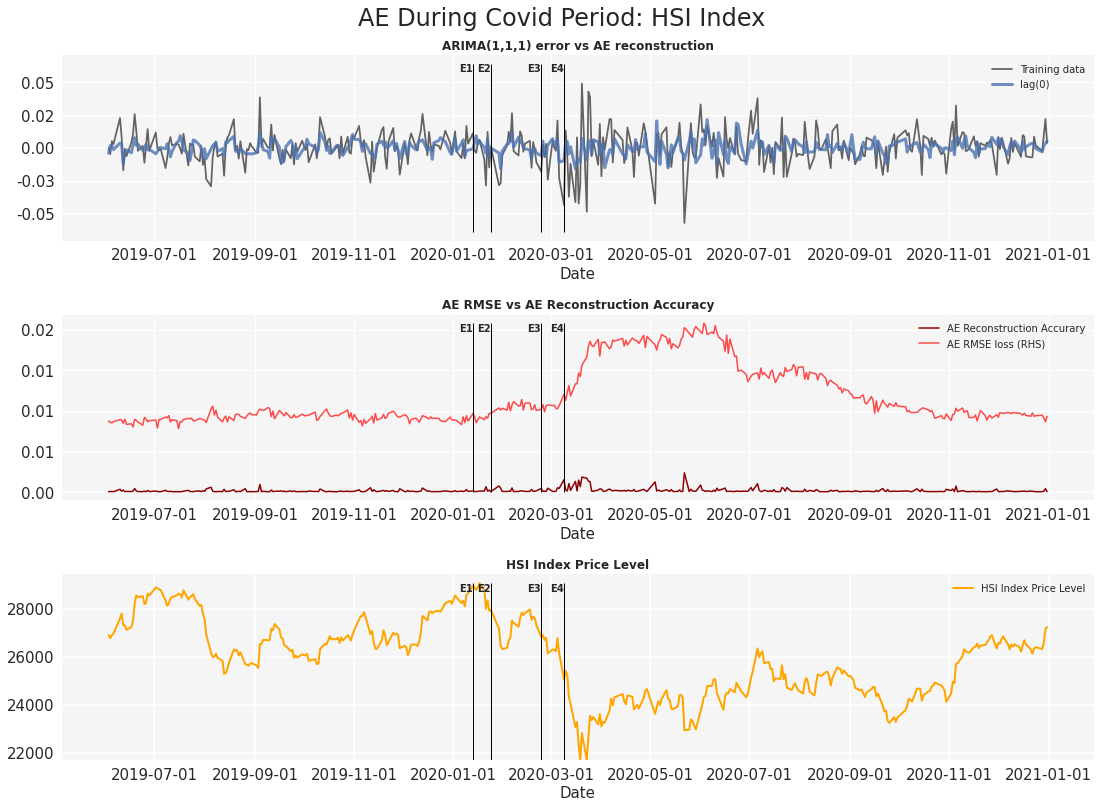

In [160]:
if show_plots:
    # determine slices to plot
    price_slice = prices[(prices.index>'2019-06-01')&(prices.index<'2021-01-01')]
    x_slice = x_full['l0'][(x_full.index>'2019-06-01')&(x_full.index<'2021-01-01')]
    full_slice = full_pred['l0'][(full_pred.index>'2019-06-01')&(full_pred.index<'2021-01-01')]
    reshifted_slice = reshifted_rmse_loss[(reshifted_rmse_loss.index>'2019-06-01')&(reshifted_rmse_loss.index<'2021-01-01')]
    rmse_slice = full_rmse_loss[(full_rmse_loss.index>'2019-06-01')&(full_rmse_loss.index<'2021-01-01')]
    # generate axes
    fig, axs = plt.subplots(3)
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    # Insert heading
    fig.suptitle('AE During Covid Period: '+str(MKT).replace('.',' '), y = 0.9, fontdict=TITLE_FONT)    
    fig.subplots_adjust(hspace=0.4, top=0.85)

    # Axis 1
    ax1.plot(x_slice, alpha=.6, color='black', label='Training data')
    ax1.plot(full_slice, alpha=.8, label='lag(0)', linewidth=3)
    # Vertical lines
    ax1.vlines(E1, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E2, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E3, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E4, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)

    ax1.text(E1, full_slice.max()*3, 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E2, full_slice.max()*3, 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E3, full_slice.max()*3, 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E4, full_slice.max()*3, 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    # Subtitle
    ax1.set_facecolor('whitesmoke')
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    # X axis date formatting
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date', fontdict=AXIS_FONT)
    ax1.legend()
    
    # Axis 2
    ax2.plot(reshifted_slice, color='darkred', label='AE Reconstruction Accurary', linewidth=1.5)
    ax2.plot(rmse_slice, alpha=0.7, color='red', label='AE RMSE loss (RHS)', linewidth=1.5)
    # Vertical lines
    ax2.vlines(E1, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E2, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E3, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E4, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)

    ax2.text(E1, rmse_slice.max(), 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E2, rmse_slice.max(), 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E3, rmse_slice.max(), 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E4, rmse_slice.max(), 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax2.title.set_text('AE RMSE vs AE Reconstruction Accuracy')
    ax2.title.set_fontweight('semibold')
    ax2.set_facecolor('whitesmoke')
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date', fontdict=AXIS_FONT)
    ax2.legend()

    # Axis 3
    ax3.plot(price_slice, color='orange', label=str(MKT).replace('.',' ')+' Price Level', linewidth=2)
    # Vertical lines
    ax3.vlines(E1, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)
    ax3.vlines(E2, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)
    ax3.vlines(E3, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)
    ax3.vlines(E4, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)

    ax3.text(E1, price_slice.max()[0], 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E2, price_slice.max()[0], 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E3, price_slice.max()[0], 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E4, price_slice.max()[0], 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax3.title.set_text(str(MKT).replace('.',' ')+' Price Level')
    ax3.title.set_fontweight('semibold')
    ax3.set_ylim(ymin=price_slice.min()[0])
    ax3.set_facecolor('whitesmoke')
    ax3.xaxis.set_major_formatter(DATE_FORM)
    # ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_xlabel('Date', fontdict=AXIS_FONT)
    ax3.legend()

    # General Fig settings
    fig.set_size_inches(18.5, 13.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_out-sample_predictions_vs_actual__close-up.png',
                dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
else:
    print('Not storing plot.')

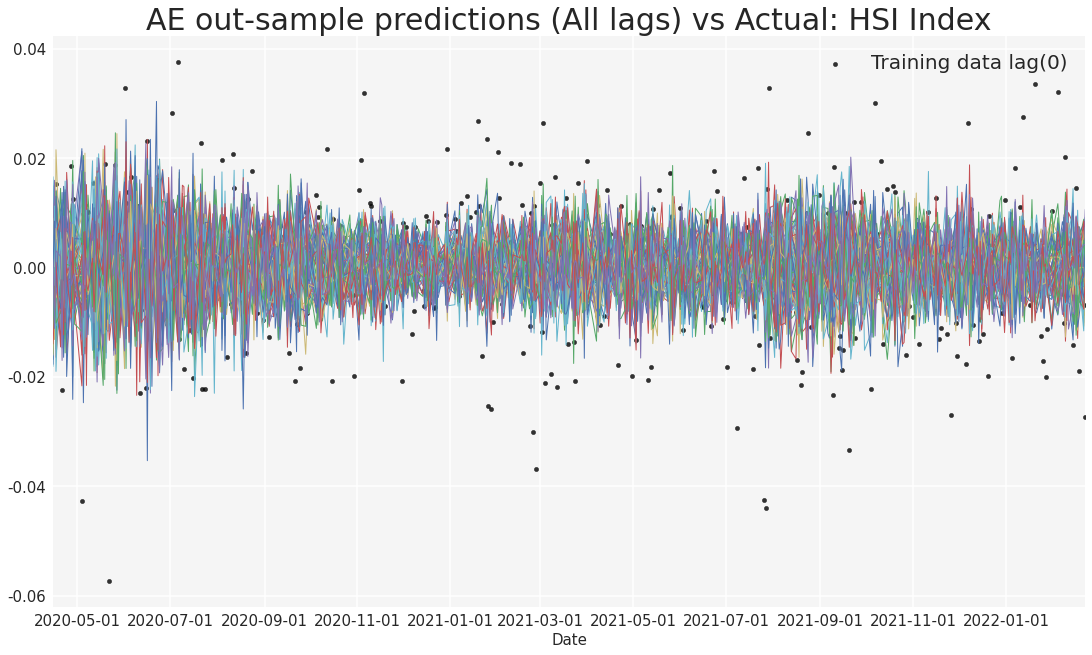

In [183]:
if show_plots:
    fig, ax = plt.subplots()

    ax.scatter(x_test['l0'].index,x_test['l0'], alpha=.8, s=20, color='black', label='Training data lag(0)')
    for i in range(test_pred.shape[1]):
        ax.plot(test_pred['l'+str(i)], linewidth=1) #, label = 'l'+str(i)
        
    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(DATE_FORM)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Date',fontdict=AXIS_FONT)

    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':20})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE out-sample predictions (All lags) vs Actual: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_out-sample_predictions_all_lags_vs_actual.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

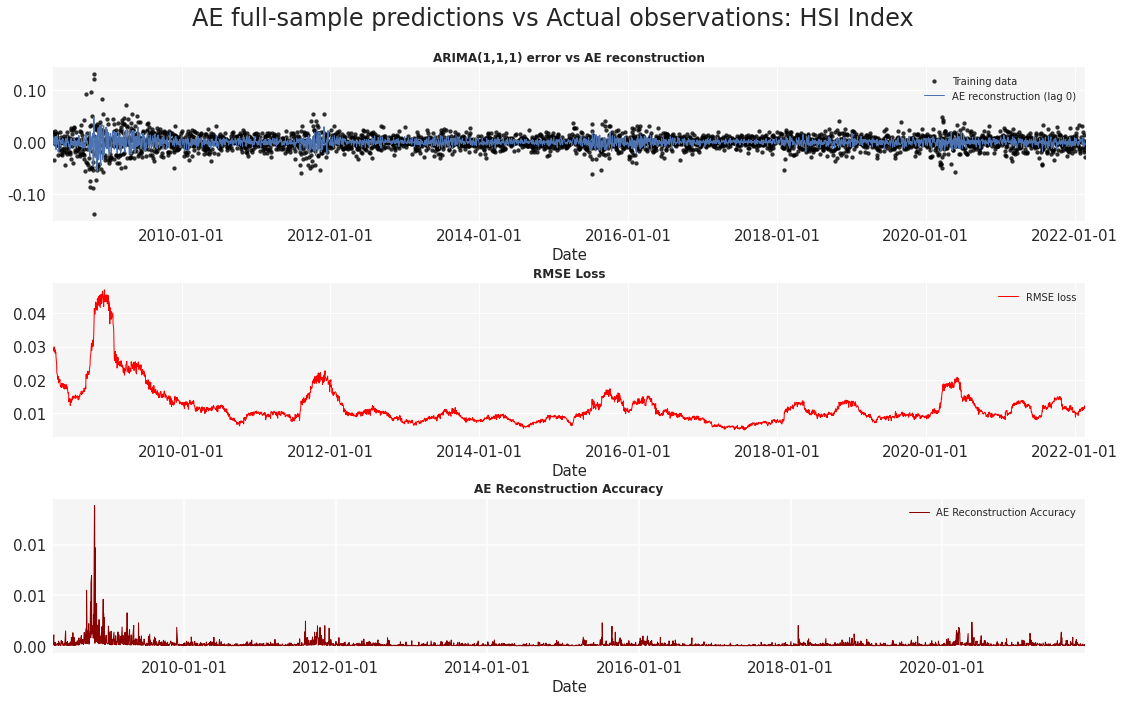

In [213]:
if show_plots:
    # Generate axes
    fig, axs = plt.subplots(3)
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]

    # Insert Title
    fig.suptitle('AE full-sample predictions vs Actual observations: '+str(MKT).replace('.',' '), y = 0.98, fontdict=TITLE_FONT)
    fig.subplots_adjust(hspace=0.4, top=0.90)

    # Axis 1
    ax1.scatter(x_full['l0'].index, x_full['l0'], alpha=.8, s=15, color='black', label='Training data')
    ax1.plot(full_pred['l0'], linewidth=1, label='AE reconstruction (lag 0)')
    # ax1 settings
    ax1.set_facecolor('whitesmoke')
    ax1.margins(x=0)
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date',fontdict=AXIS_FONT)
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    ax1.legend()

    # Axis 2
    ax2.plot(full_rmse_loss, color='red', label='RMSE loss', linewidth=1)
    # ax.plot(ewm_full_pred, linewidth=1.5)
    # ax2 settings
    ax2.set_facecolor('whitesmoke')
    ax2.margins(x=0)
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date',fontdict=AXIS_FONT)
    ax2.title.set_text('RMSE Loss')
    ax2.title.set_fontweight('semibold')
    ax2.legend()
    
    # Axis 3
    ax3.plot(reshifted_rmse_loss, color='darkred', label='AE Reconstruction Accuracy', linewidth=1)
    ax3.set_facecolor('whitesmoke')
    ax3.margins(x=0)
    ax3.xaxis.set_major_formatter(DATE_FORM)
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_xlabel('Date',fontdict=AXIS_FONT)
    ax3.title.set_text('AE Reconstruction Accuracy')
    ax3.title.set_fontweight('semibold')
    ax3.legend()

    # Figure settings
    fig.set_size_inches(18.5, 10.5)

    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_full-sample_predictions_vs_actual.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [42]:
d_ae_plots+'AE_full-sample_predictions_vs_actual.png'

'C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/results/fanomal/stats_models/ae_results/HSI.Index/plots/AE_full-sample_predictions_vs_actual.png'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


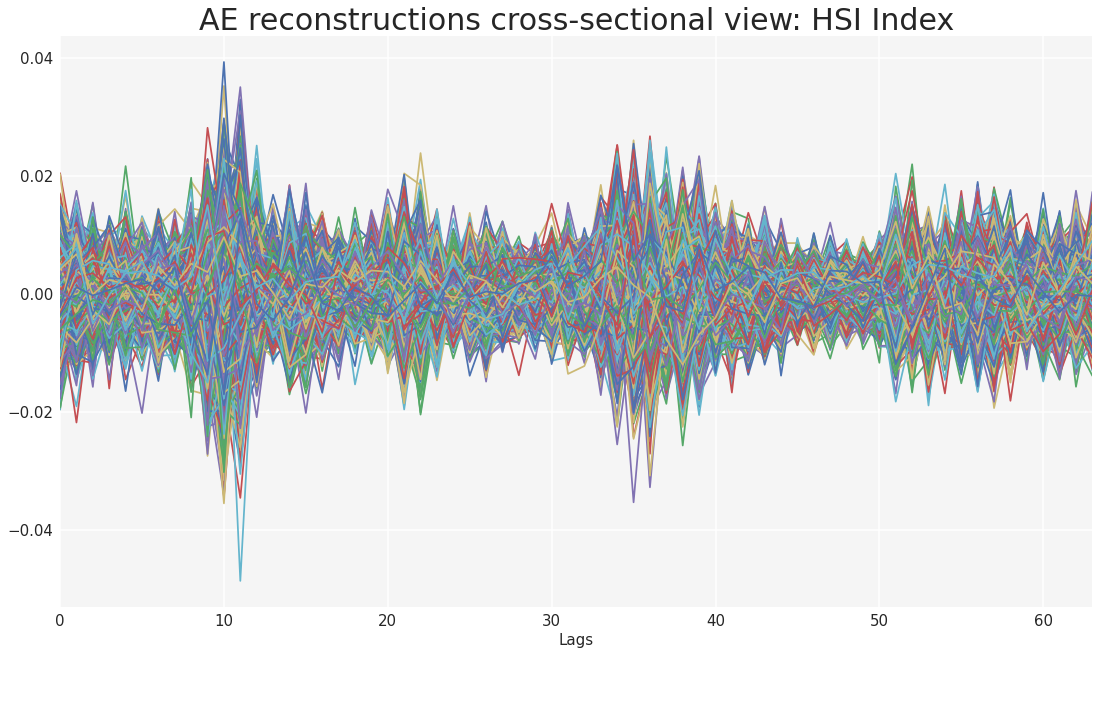

In [184]:
if show_plots:
    fig, ax = plt.subplots()

    ax.plot(x_train_pred.reshape(x_train_pred.shape[1],x_train_pred.shape[0]))

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    ax.set_xlabel('Lags', fontdict=AXIS_FONT)

    fig.legend(loc='lower center', ncol=2, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE reconstructions cross-sectional view: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_prediction_cross_section.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Keegan\AppData\Local\Temp\ipykernel_18808\3749259699.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


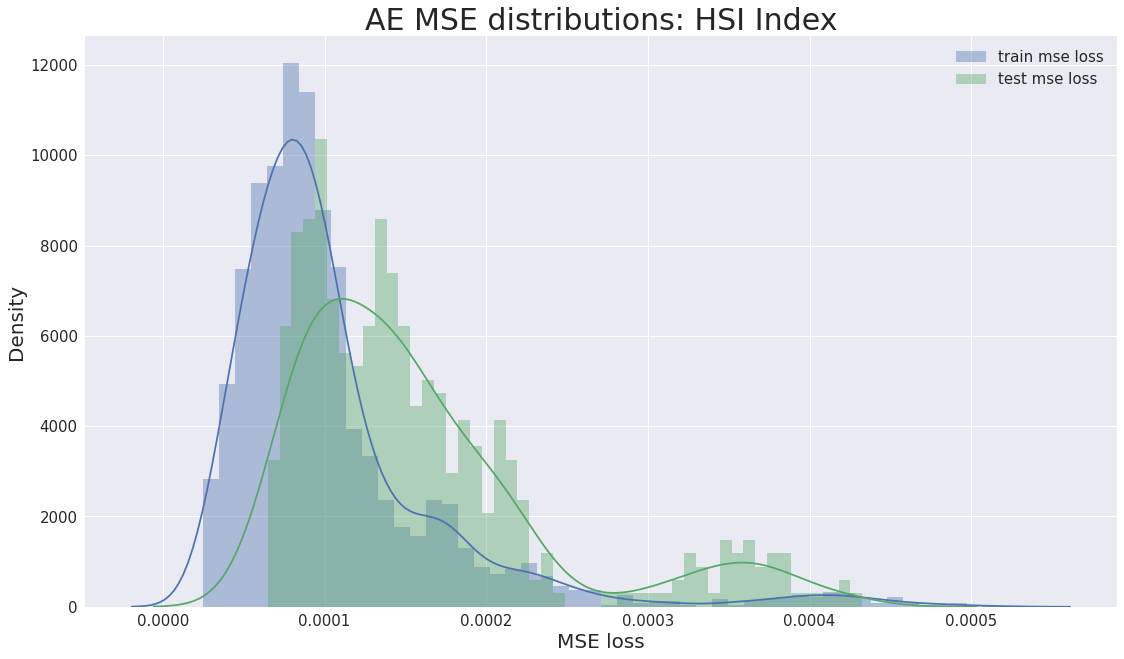

In [44]:
if show_plots:
    fig, ax = plt.subplots()

    sns.distplot(train_mse_loss, bins=50, label='train mse loss', ax=ax)
    sns.distplot(test_mse_loss, bins=50, label='test mse loss', ax=ax)
    # sns.distplot(full_mse_loss, bins=50, label='full mse loss', ax=ax)
    
    ax.set_xlabel("MSE loss", fontdict=AXIS_FONT)
    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.title('AE MSE distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'test_train_mse_loss_distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

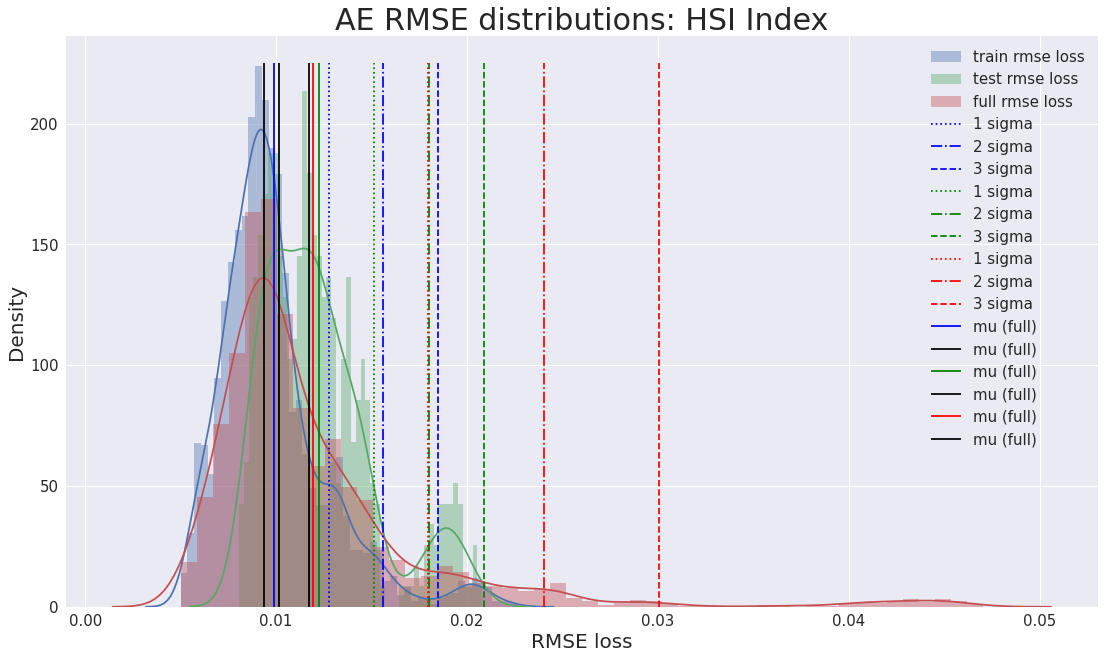

In [45]:
if show_plots:

    fig, ax = plt.subplots()

    sns.distplot(train_rmse_loss, bins=50, label='train rmse loss', ax=ax)
    sns.distplot(test_rmse_loss, bins=50, label='test rmse loss', ax=ax)
    sns.distplot(full_rmse_loss, bins=50, label='full rmse loss', ax=ax)

    ax.vlines(train_rmse_loss.mean() + train_rmse_loss.std(), ymin=0, ymax=225, color='blue', label='1 sigma', linestyle ='dotted')
    ax.vlines(train_rmse_loss.mean() +2*train_rmse_loss.std(), ymin=0, ymax=225, color='blue', label='2 sigma', linestyle ='dashdot')
    ax.vlines(train_rmse_loss.mean() +3*train_rmse_loss.std(), ymin=0, ymax=225, color='blue', label='3 sigma', linestyle ='--')

    ax.vlines(test_rmse_loss.mean() + test_rmse_loss.std(), ymin=0, ymax=225, color='green', label='1 sigma', linestyle ='dotted')
    ax.vlines(test_rmse_loss.mean() +2*test_rmse_loss.std(), ymin=0, ymax=225, color='green', label='2 sigma', linestyle ='dashdot')
    ax.vlines(test_rmse_loss.mean() +3*test_rmse_loss.std(), ymin=0, ymax=225, color='green', label='3 sigma', linestyle ='--')

    ax.vlines(full_rmse_loss.mean() + full_rmse_loss.std(), ymin=0, ymax=225, color='red', label='1 sigma', linestyle ='dotted')
    ax.vlines(full_rmse_loss.mean() +2*full_rmse_loss.std(), ymin=0, ymax=225, color='red', label='2 sigma', linestyle ='dashdot')
    ax.vlines(full_rmse_loss.mean() +3*full_rmse_loss.std(), ymin=0, ymax=225, color='red', label='3 sigma', linestyle ='--')

    ax.vlines(train_rmse_loss.mean(), ymin=0, ymax=225, color='blue', label='mu (full)', linestyle ='-')
    ax.vlines(train_rmse_loss.median(), ymin=0, ymax=225, color='black', label='mu (full)', linestyle ='-')
    ax.vlines(test_rmse_loss.mean(), ymin=0, ymax=225, color='green', label='mu (full)', linestyle ='-')
    ax.vlines(test_rmse_loss.median(), ymin=0, ymax=225, color='black', label='mu (full)', linestyle ='-')
    ax.vlines(full_rmse_loss.mean(), ymin=0, ymax=225, color='red', label='mu (full)', linestyle ='-')
    ax.vlines(full_rmse_loss.median(), ymin=0, ymax=225, color='black', label='mu (full)', linestyle ='-')

    ax.set_xlabel("RMSE loss", fontdict=AXIS_FONT)
    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.title('AE RMSE distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'test_train_mse_loss_distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

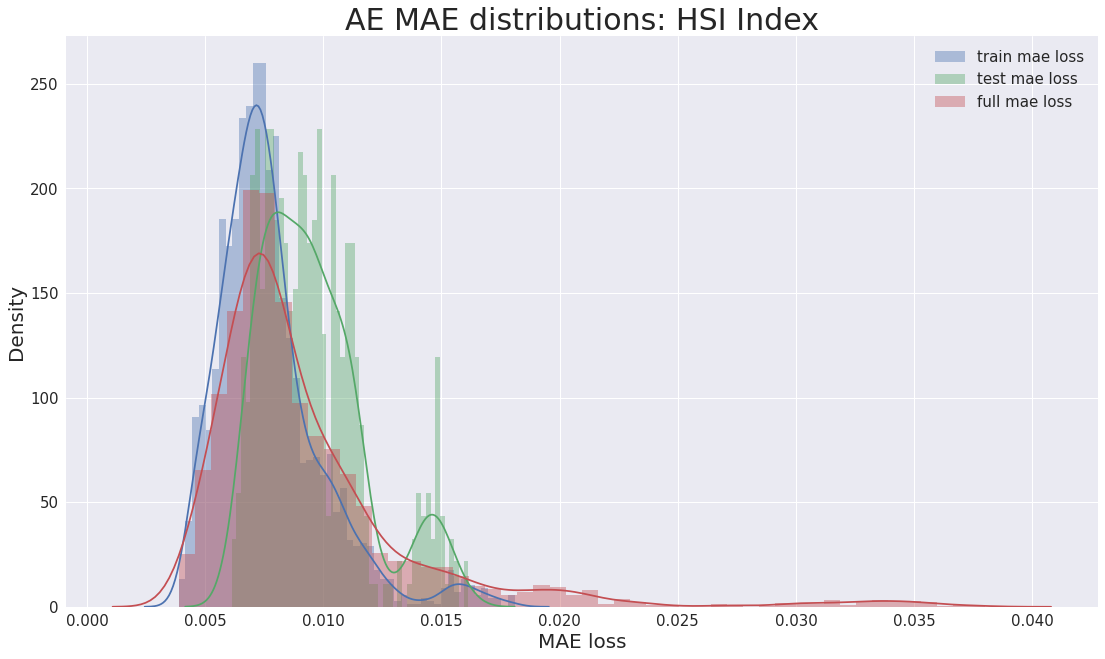

In [46]:
if show_plots:
    fig, ax = plt.subplots()
    
    sns.distplot(train_mae_loss, bins=50, label='train mae loss', ax=ax)
    sns.distplot(test_mae_loss, bins=50, label='test mae loss', ax=ax)
    sns.distplot(full_mae_loss, bins=50, label='full mae loss', ax=ax)
    ax.set_xlabel("MAE loss", fontdict=AXIS_FONT)
    ax.set_ylabel("Density", fontdict=AXIS_FONT)

    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.title('AE MAE distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'test_train_mae_loss_distributions.png', dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

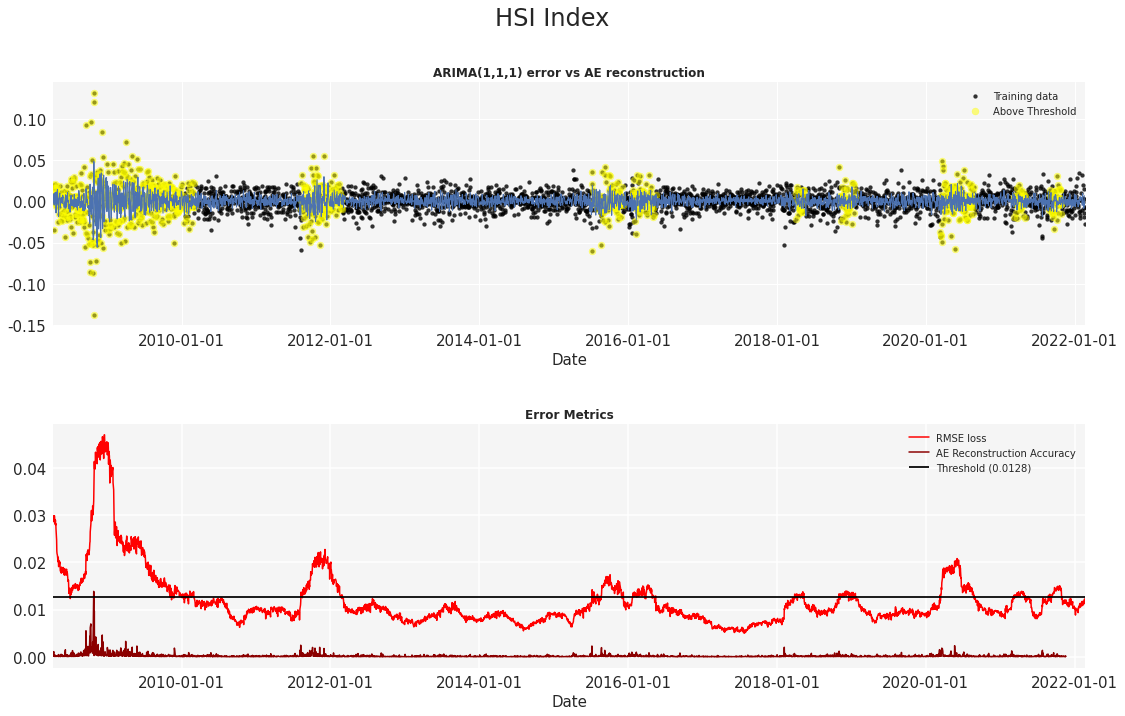

In [217]:
if show_plots:
    # Some formatting
    # PE = [pe.Stroke(linewidth=0.3, foreground='black'), pe.Normal()]
    THRESHOLD = train_rmse_loss.mean()+1*train_rmse_loss.std()
    # Generate Axes
    fig, axs = plt.subplots(2)
    ax1 = axs[0]
    ax2 = axs[1]
    # Insert Title
    fig.suptitle(str(MKT).replace('.',' '), y=1, fontdict=TITLE_FONT)
    fig.subplots_adjust(hspace=0.4, top=0.9)

    # Axis 1
    ax1.scatter(x_full['l0'].index,x_full['l0'], alpha=.8, s=15, color='black', label='Training data')
    ax1.plot(full_pred['l0'], linewidth=1)
    ax1.scatter(x_full['l0'][full_rmse_loss>=THRESHOLD].index, x_full['l0'][full_rmse_loss>=THRESHOLD], s=50, alpha=0.5, color='yellow', label='Above Threshold')
    
    ax1.set_facecolor('whitesmoke')
    ax1.margins(x=0)
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date',fontdict=AXIS_FONT)
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    ax1.legend()

    # Axis 2
    ax2.plot(full_rmse_loss, color='red', label='RMSE loss', linewidth=1.5) #, path_effects = PE
    ax2.plot(reshifted_rmse_loss, color='darkred', label='AE Reconstruction Accuracy', linewidth=1.5)
    ax2.hlines(THRESHOLD, xmin=full_rmse_loss.index[0], xmax=full_rmse_loss.index[-1], color='black', label='Threshold ('+str(round(THRESHOLD, 4))+')')
    # ax2.scatter(full_rmse_loss[full_rmse_loss> THRESHOLD].index, full_rmse_loss[full_rmse_loss>THRESHOLD], s=50, alpha=0.5, color='yellow', label='Above RMSE Threshold: '+str(round(THRESHOLD, 4)))
    # ax.plot(ewm_full_pred, linewidth=1.5)

    ax2.set_facecolor('whitesmoke')
    ax2.margins(x=0)
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date',fontdict=AXIS_FONT)
    ax2.title.set_text('Error Metrics')
    ax2.title.set_fontweight('semibold')
    ax2.legend()
    
    # fig.legend(loc=8, ncol=16, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_full-sample_predictions_vs_actual.png',
    dpi=400, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

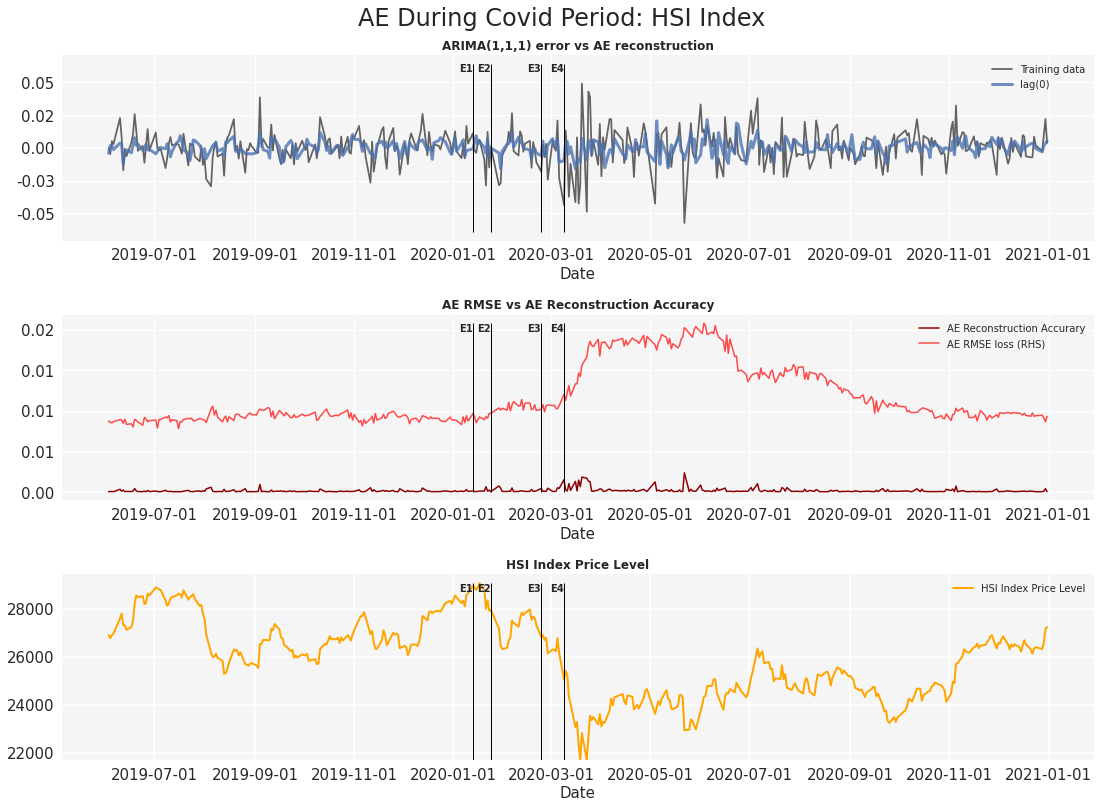

In [ ]:
if show_plots:
    # determine slices to plot
    price_slice = prices[(prices.index>'2019-06-01') & (prices.index<'2021-01-01')]
    x_slice = x_full['l0'][(x_full.index>'2019-06-01') & (x_full.index<'2021-01-01')]
    full_slice = full_pred['l0'][(full_pred.index>'2019-06-01') & (full_pred.index<'2021-01-01')]
    reshifted_slice = reshifted_rmse_loss[(reshifted_rmse_loss.index>'2019-06-01') & (reshifted_rmse_loss.index<'2021-01-01')]
    rmse_slice = full_rmse_loss[(full_rmse_loss.index>'2019-06-01') & (full_rmse_loss.index<'2021-01-01')]
    # generate axes
    fig, axs = plt.subplots(3)
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    # Insert heading
    fig.suptitle('AE During Covid Period: '+str(MKT).replace('.',' '), y = 0.9, fontdict=TITLE_FONT)    
    fig.subplots_adjust(hspace=0.4, top=0.85)

    # Axis 1
    ax1.plot(x_slice, alpha=.6, color='black', label='Training data')
    ax1.plot(full_slice, alpha=.8, label='lag(0)', linewidth=3)
    # Vertical lines
    ax1.vlines(E1, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E2, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E3, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E4, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)

    ax1.text(E1, full_slice.max()*3, 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E2, full_slice.max()*3, 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E3, full_slice.max()*3, 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E4, full_slice.max()*3, 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    # Subtitle
    ax1.set_facecolor('whitesmoke')
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    # X axis date formatting
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date', fontdict=AXIS_FONT)
    ax1.legend()
    
    # Axis 2
    ax2.plot(reshifted_slice, color='darkred', label='AE Reconstruction Accurary', linewidth=1.5)
    ax2.plot(rmse_slice, alpha=0.7, color='red', label='AE RMSE loss (RHS)', linewidth=1.5)
    # Vertical lines
    ax2.vlines(E1, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E2, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E3, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E4, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)

    ax2.text(E1, rmse_slice.max(), 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E2, rmse_slice.max(), 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E3, rmse_slice.max(), 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E4, rmse_slice.max(), 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax2.title.set_text('AE RMSE vs AE Reconstruction Accuracy')
    ax2.title.set_fontweight('semibold')
    ax2.set_facecolor('whitesmoke')
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date', fontdict=AXIS_FONT)
    ax2.legend()

    # Axis 3
    ax3.plot(price_slice, color='orange', label=str(MKT).replace('.',' ')+' Price Level', linewidth=2)
    # Vertical lines
    ax3.vlines(E1, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)
    ax3.vlines(E2, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)
    ax3.vlines(E3, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)
    ax3.vlines(E4, ymin=price_slice.min()[0], ymax=price_slice.max()[0], color='black', linewidth=1)

    ax3.text(E1, price_slice.max()[0], 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E2, price_slice.max()[0], 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E3, price_slice.max()[0], 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E4, price_slice.max()[0], 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax3.title.set_text(str(MKT).replace('.',' ')+' Price Level')
    ax3.title.set_fontweight('semibold')
    ax3.set_ylim(ymin=price_slice.min()[0])
    ax3.set_facecolor('whitesmoke')
    ax3.xaxis.set_major_formatter(DATE_FORM)
    # ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_xlabel('Date', fontdict=AXIS_FONT)
    ax3.legend()

    # General Fig settings
    fig.set_size_inches(18.5, 13.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_out-sample_predictions_vs_actual__close-up.png',
                dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
else:
    print('Not storing plot.')

Attempts to Predict RMSE

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


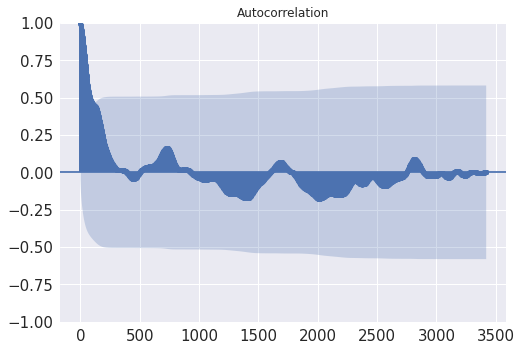

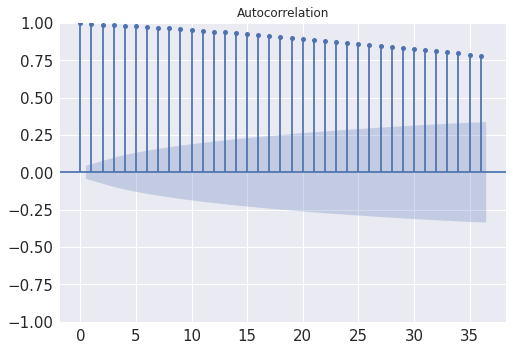

In [218]:
pm.plot_acf(full_rmse_loss,lags=full_rmse_loss.shape[0]-1, alpha=0.01)
pm.plot_acf(full_rmse_loss, alpha=0.01)
pm.plot_pacf(full_rmse_loss, alpha=0.01)

In [51]:
alags = [1,2,3,4]

In [220]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [219]:
check_stationarity(full_rmse_loss)

ADF Statistic: -3.735507
p-value: 0.003641
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


RMSE Predictive models

In [54]:
from statsmodels.tsa.ar_model import AutoReg
ar = AutoReg(endog = train_rmse_loss.values, lags=alags, trend='ct').fit() # trend= ['n','c','t','ct']
# ar.summary()
ar_pred = ar.predict(dynamic=False)

Aarima = pm.auto_arima(train_rmse_loss.values, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,)
Aarima.summary()
Aarima_pred = Aarima.predict_in_sample(dynamic=False)


# Fit a simple ols model
# ols = OLS(train_rmse_loss, hasconst=True).fit()
# ols_fit = ols.predict(train_rmse_loss)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-29607.467, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28988.575, Time=0.91 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29451.141, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29596.231, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28990.571, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-29593.343, Time=0.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-29608.167, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29594.812, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29593.282, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-29606.399, Time=0.92 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-29607.007, Time=0.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-28978.487, Time=2.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-29610.148, Time=0.77 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-29596.967, Time=0.47 sec
 ARIM

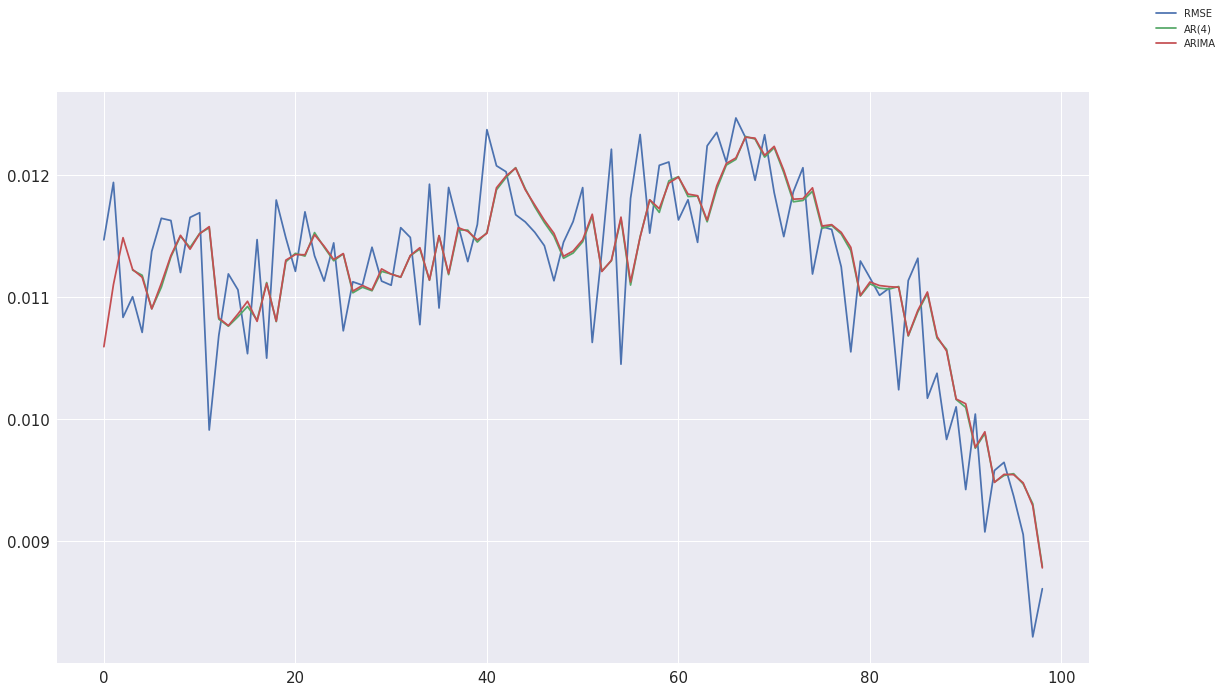

In [55]:
fig, ax = plt.subplots()
ax.plot(train_rmse_loss.values[1:100], label='RMSE')
ax.plot(ar_pred[1:100], label='AR(4)')
ax.plot(Aarima_pred[1:100], label='ARIMA')
# ax.plot(ols_fit[1:100], label='OLS')

fig.set_size_inches(18.5, 10.5)
fig.legend()
# plt.plot(train_rmse_loss.values-ar_pred)

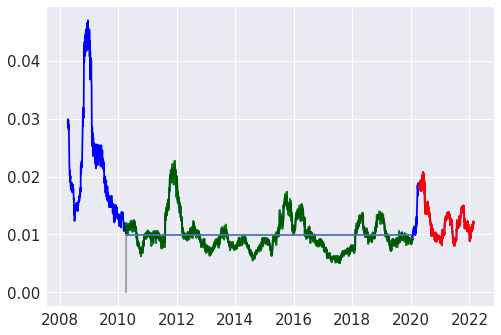

In [56]:
plt.plot(full_rmse_loss, color='blue')
plt.plot(train_rmse_loss, color='green')
plt.plot(test_rmse_loss, color='red')
plt.plot(train_rmse_loss.index, Aarima_pred, alpha=0.3, linewidth=2, color='black')
plt.hlines(train_rmse_loss.mean(),xmin=train_rmse_loss.index[0],xmax=train_rmse_loss.index[-1])

.______________________________.

EMV Indices

In [57]:
# specify directories
d_emv = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/evm_indices/"
d_infectious = d_emv+'All_Infectious_'+'EMV_Data'+'.csv'
d_emv = d_emv+'EMV_Data'+'.xlsx'

emv = pd.read_excel(d_emv)
infectious = pd.read_csv(d_infectious)
# wrangle date information

# INFECTIOUS
dates = infectious[['day','month','year']].astype('str')
dates['date']=pd.to_datetime([dates['year'][i]+'-'+dates['month'][i]+'-'+dates['day'][i] for i in range(len(dates))])
infectious['date'] = dates.date
infectious = infectious.drop(['day','month','year'], axis=1).set_index('date')
del dates

# EMV
# end of month days
day_dct = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}

emv = emv.drop(emv.tail(1).index)
emv[['Year','Month']] = emv[['Year','Month']].astype('int64').round(decimals=0)
dates = emv[['Month','Year']].astype('str')
dates['day'] = '01'
dates['Month'] = [str(string).zfill(2) for string in dates['Month']]
for key, val in day_dct.items():
    # make end of month
    dates['day'][dates['Month']==key] = str(val)
dates['date']= pd.to_datetime([dates['Year'][i]+'-'+dates['Month'][i]+'-'+dates['day'][i] for i in range(len(dates))])
emv['date'] = dates.date
emv = emv.drop(['Month','Year'], axis=1).set_index('date')

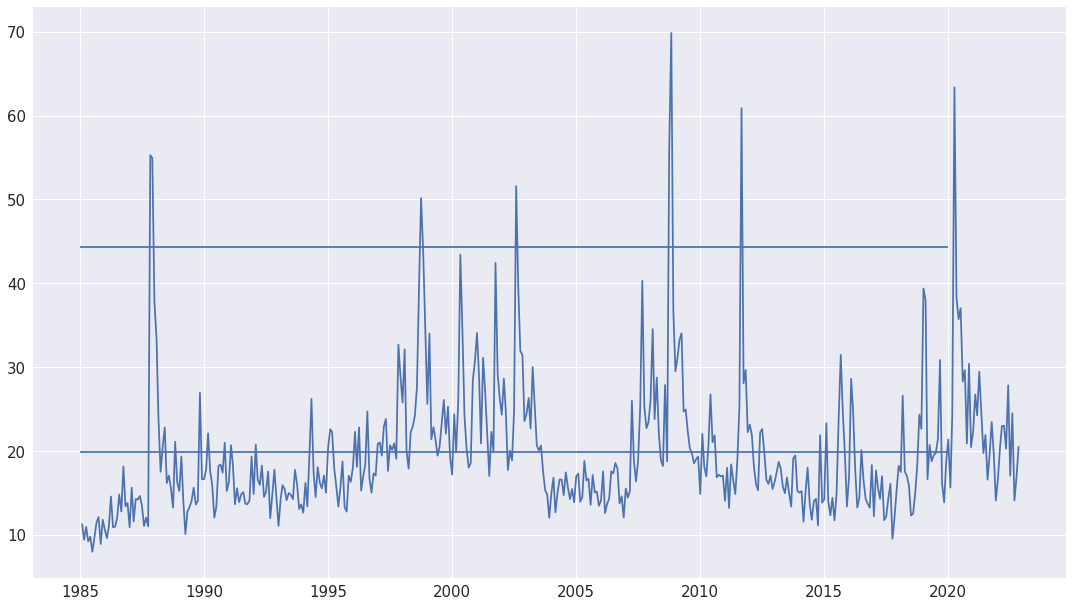

In [58]:
fig, ax = plt.subplots()

# ax.plot(infectious.index,infectious.values.reshape(len(infectious)))
ax.plot(emv['Overall EMV Tracker'])
ax.hlines(emv['Overall EMV Tracker'].mean(),xmin=pd.to_datetime('1985-01-01'),xmax=pd.to_datetime('2020-01-01'))
ax.hlines(emv['Overall EMV Tracker'].mean()+emv['Overall EMV Tracker'].std()*3,xmin=pd.to_datetime('1985-01-01'),xmax=pd.to_datetime('2020-01-01'))
fig.set_size_inches(18.5, 10.5)

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


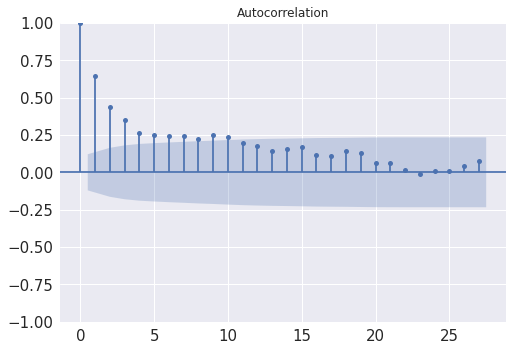

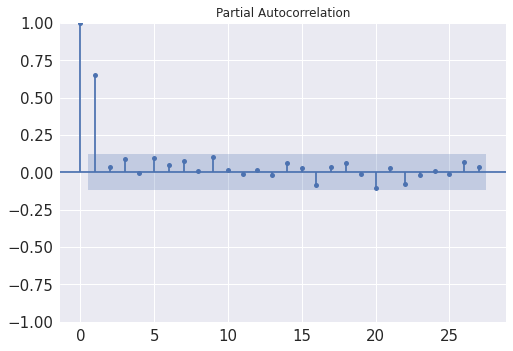

In [59]:
pm.plot_acf(emv['Overall EMV Tracker'],alpha=.01)
pm.plot_pacf(emv['Overall EMV Tracker'],alpha=.01)

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


ValueError: cannot convert float NaN to integer

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


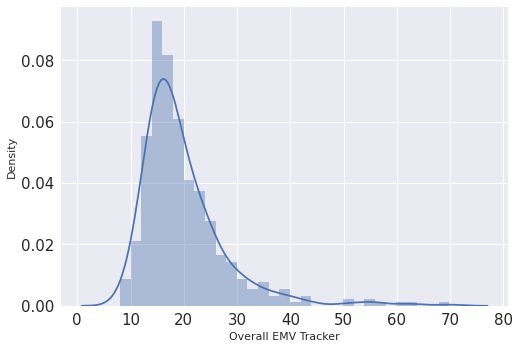

In [60]:
sns.distplot(emv['Overall EMV Tracker'])
sns.distplot(infectious.pct_change().dropna())

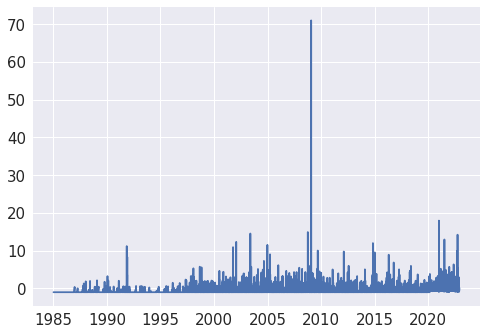

In [ ]:
inf_change = infectious.pct_change()
inf_change = inf_change[~inf_change.pct_change().isin([np.nan, np.inf, -np.inf]).any(1)].dropna()
plt.plot(inf_change)